# Data Preparation and Analysis
student_number: 24284209

data_source: property sale register


## Importing Libraries
This cell imports all necessary libraries for data analysis, visualisation, and machine learning:
- pandas and numpy for data manipulation
- matplotlib and seaborn for visualisations
- xgboost for gradient boosing models
- scipy for statistical tests
- sklearn modules for machine learning pipelines, preprocessing, and model eval

In [341]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import xgboost as xgb

from scipy import stats
from sklearn.compose import ColumnTransformer, TransformedTargetRegressor
from sklearn.ensemble import GradientBoostingRegressor, RandomForestRegressor, StackingRegressor
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score, root_mean_squared_error
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder, StandardScaler

import warnings
warnings.filterwarnings('ignore')

## Data Loading
Load the raw dataset from CSV and displays the first few rows to inspect the data structure. the dataset contains property sales information including locations, prices, and property characteristics.

In [342]:
df = pd.read_csv("./unprepared_df.csv")
df.head()

,Unnamed: 0,Year,Sale Date,Sale Price,Property Location,Year Built,Garden,Garage,Type,Style,Bedrooms,Bathrooms,First Time Buyer
0,0,2021,Sold 2021-01-10,"€381,302.00",Broomhouse,1967,Yes,Yes,Detached,1.5-Storey,3,1,No
1,1,2021,Sold 2021-01-10,"€325,898.00",Broomhouse,1978,Yes,???,Detached,1-Storey,3,1,Yes
2,2,2021,Sold 18 January 2021,"€ 370,354",Oak Park,1961,Yes,No,Detached,1-Storey,3,2,No
3,3,2021,Sold 2021-01-23,"€92,480.00",Beacon Hill,1958,Yes,No,Bungalow,1-Storey,1,1,Yes
4,4,2021,Sold 2021-01-25,"€312,030.00",Brookville,1987,Yes,Yes,Detached,1-Storey,3,1,No


## Data Cleaning and Transformations
Performs essential data cleaning:
1. Extracts and converts dates to datetime format
2. Cleans price values by removing currency symbols and commas
3. Handles missing build year values using median imputation by property type
4. Simplifies style descriptions by removing redundant text

In [343]:
df['Sale Date'] = pd.to_datetime(df['Sale Date'].str[4:], format='mixed')

df['Sale Price'] = df['Sale Price'].str[1:].str.replace(',','').astype('float')

df['Year Built'] = pd.to_numeric(df['Year Built'].str.replace('c',''), errors='coerce')
median_year_by_type = df.groupby('Type')['Year Built'].median().to_dict()
df['Year Built'] = df.apply(
    lambda row: median_year_by_type.get(row['Type'], df['Year Built'].median())
    if pd.isna(row['Year Built']) else row['Year Built'],
    axis = 1
)

df['Style'] = df['Style'].str.replace('-Storey', '')


## Data Type Conversion and Cleanup
Performs several transformations:
1. Converts categorical variables to proper formats
2. Standardises property types (e.g., Semi-D to Semi-Detached, as both exist otherwise)
3. Converts boolean fields to proper boolean types
4. Sets appropriate data types for categorical and numeric columns
5. Drops columns that are not necessary

In [344]:
df['Garden'] = df['Garden'].map({"Yes": "True", "No": "False", "???": np.nan})

df['Garage'] = df['Garage'].map({"Yes": "True", "No": "False", "???": np.nan})

df['Type'] = df['Type'].replace({"Semi-D": 'Semi-Detached', "Det.": "Detached"})

df['First Time Buyer'] = df['First Time Buyer'].str.lower().map({'yes': True, 'no': False})
df['First Time Buyer'] = df['First Time Buyer'].astype('bool')

cat_cols = ['Property Location', 'Garden', 'Garage', 'Type', 'Style']
for col in cat_cols:
    df[col] = df[col].astype('category')

num_cols = ['Bedrooms', 'Bathrooms']
for col in num_cols:
    df[col] = df[col].astype('int')

df = df.drop(columns=["Unnamed: 0", "Year"])

df.head()

,Sale Date,Sale Price,Property Location,Year Built,Garden,Garage,Type,Style,Bedrooms,Bathrooms,First Time Buyer
0,2021-01-10,381302.0,Broomhouse,1967.0,True,True,Detached,1.5,3,1,False
1,2021-01-10,325898.0,Broomhouse,1978.0,True,NaN,Detached,1,3,1,True
2,2021-01-18,370354.0,Oak Park,1961.0,True,False,Detached,1,3,2,False
3,2021-01-23,92480.0,Beacon Hill,1958.0,True,False,Bungalow,1,1,1,True
4,2021-01-25,312030.0,Brookville,1987.0,True,True,Detached,1,3,1,False


In [345]:
df.isnull().sum()


Sale Date             0
Sale Price            0
Property Location     0
Year Built            0
Garden               28
Garage               84
Type                  0
Style                 0
Bedrooms              0
Bathrooms             0
First Time Buyer      0
dtype: int64

## Data Type Verification and Null Handling
1. Fill missing values in numeric columns with median values
2. Fill missing values in categorical columns with mode values
3. Verify that no null values remain in the dataset

In [346]:
numeric_cols = df.select_dtypes(include=['int', 'float']).columns
for col in numeric_cols:
    df[col] = df[col].fillna(df[col].median())

categorical_cols = df.select_dtypes(include=['category']).columns
for col in categorical_cols:
    df[col] = df[col].fillna(df[col].mode()[0])

# check for nulls
df.isnull().sum()

Sale Date            0
Sale Price           0
Property Location    0
Year Built           0
Garden               0
Garage               0
Type                 0
Style                0
Bedrooms             0
Bathrooms            0
First Time Buyer     0
dtype: int64

## Feature Engineering
Create derived features to enhance future model performance.
Features like:
- Building Age
- Time-based Features
- Moving Averages
- Location-based Price Metrics
- Room-based Price Metrics
- Age-based features and interactions
- Binary Flags for features like is it a luxury property (this could contribute to leakage... but would be easier to diagnose in real life).


In [347]:
date_features = {
    'Building Age': 2025 - df['Year Built'],
    'Sale Month': df['Sale Date'].dt.month,
    'Sale Year': df['Sale Date'].dt.year,
    'Sale Quarter': df['Sale Date'].dt.quarter,
    'Sale Day of Week': df['Sale Date'].dt.day_of_week,
    'Sale Week of Year': df['Sale Date'].dt.isocalendar().week,
    'Days Since First Sale': (df['Sale Date'] - df['Sale Date'].min()).dt.days
}

df = df.assign(**date_features)

# moving averages
df = df.sort_values('Sale Date')
df['Price 30 Day MA'] = df['Sale Price'].rolling(window=30).mean()
df['Price 90 Day MA'] = df['Sale Price'].rolling(window=90).mean()
df = df.fillna({
    'Price 30 Day MA': df['Sale Price'].mean(),
    'Price 90 Day MA': df['Sale Price'].mean()
})

location_median = df.groupby('Property Location')['Sale Price'].median().reset_index()
location_median.columns = ['Property Location', 'Location Median Price']
df = df.merge(location_median, on='Property Location', how='left')

# price relative to location
df['Price vs Location Median'] = df['Sale Price'] / df['Location Median Price']

# room based
df['Total Rooms'] = df['Bedrooms'] + df['Bathrooms']
df['Bedroom to Bathroom Ratio'] = df['Bedrooms'] / (df['Bathrooms'] + 0.001) #if 0 bathroom
df['Price per Room'] = df['Sale Price'] / df['Total Rooms']
df['Price per Bedroom'] = df['Sale Price'] / df['Bedrooms']

# building age
df['Age Bucket'] = pd.qcut(df['Building Age'], q=5, labels=False)

# price per year old ratio
df['Price per Year Old'] = df['Sale Price'] / (df['Building Age'] + 0.01)

# price percentile
df['Price Percentile'] = df.groupby('Property Location')['Sale Price'].rank(pct=True)

# Interactions
df['Bedroom x Bathroom'] = df['Bedrooms'] * df['Bathrooms']
df['Bathrooms x Age'] = df['Bathrooms'] * df['Building Age']
df['Bedrooms x Age'] = df['Bedrooms'] * df['Building Age']

# luxury?
price_75th = df['Sale Price'].quantile(0.75)
df['Luxury?'] = (df['Sale Price'] > price_75th).astype(int)

# recent build?
df['Recent Build?'] = (df['Building Age'] <= 5).astype(int)
df['Old Build?'] = (df['Building Age'] > 50).astype(int)

## Save the Prepared Data
Saves the cleaned and feature_engineered dataset to a CSV file.

In [348]:
df.to_csv('./prepared_df.csv')

## Setting Style and Basic Dataset Information
Sets visualisation styles and basic information of the dataset..

The dataset now has 1400 rows, with 36 columns. We are able to view the first few rows of the dataset to get a better understanding of its new structure.

In [349]:
# Set style
plt.style.use('ggplot')
sns.set_palette('Set1')
sns.set_context("paper")

# Display basic information
print(f"Dataset shape: {df.shape}")
print("\nFirst 5 rows:")
print(df.head())

Dataset shape: (1400, 35)

First 5 rows:
   Sale Date  Sale Price Property Location  Year Built Garden Garage  \
0 2021-01-10    381302.0        Broomhouse      1967.0   True   True   
1 2021-01-10    325898.0        Broomhouse      1978.0   True   True   
2 2021-01-18    370354.0          Oak Park      1961.0   True  False   
3 2021-01-23     92480.0       Beacon Hill      1958.0   True  False   
4 2021-01-25    312030.0        Brookville      1987.0   True   True   

       Type Style  Bedrooms  Bathrooms  ...  Price per Bedroom  Age Bucket  \
0  Detached   1.5         3          1  ...      127100.666667           3   
1  Detached     1         3          1  ...      108632.666667           2   
2  Detached     1         3          2  ...      123451.333333           3   
3  Bungalow     1         1          1  ...       92480.000000           3   
4  Detached     1         3          1  ...      104010.000000           1   

   Price per Year Old  Price Percentile  Bedroom x Bathro

## Descriptive Statistics
Calculates and displays detailed descriptive statistics for all numerical columns, providing instights into:
- Central tendency (mean, median)
- Variability (sd, min, max, quartiles)
- Distribution Characteristics

Some interesting statisticts are the Sale Price, which gives us a better understanding of the markets, the years the houses were built, and other relevant stats.

In [350]:
# Basic statistics
numeric_cols = df.select_dtypes(include=['int64', 'float64']).columns
print(df[numeric_cols].describe().T)

                            count           mean            std  \
Sale Price                 1400.0  431799.372857  176855.956643   
Year Built                 1400.0    1979.404286      31.540195   
Bedrooms                   1400.0       2.889286       0.746610   
Bathrooms                  1400.0       1.541429       0.559279   
Building Age               1400.0      45.595714      31.540195   
Days Since First Sale      1400.0     771.757143     409.275281   
Price 30 Day MA            1400.0  432144.257962   38087.460545   
Price 90 Day MA            1400.0  433092.598711   22582.136513   
Location Median Price      1400.0  405404.967143   96036.582515   
Price vs Location Median   1400.0       1.064725       0.356227   
Total Rooms                1400.0       4.430714       1.069186   
Bedroom to Bathroom Ratio  1400.0       2.072965       0.785479   
Price per Room             1400.0   99036.772343   36186.343669   
Price per Bedroom          1400.0  157388.303595   74525.56087

## Visualisations
Creates important visualisations:
1. Distribution of Sales Prices
2. Box plots of prices by property type
3. Time Series plot of average sales prices over time
4. Average Sale Price Over Time by Property Type
5. Average Sale Price Over Time by Loation
6. Facet Grid of Sale Price Histograms for Location
7. Scatter Plot of Building Age vs. Sale Price, Coloured by Property Location
8. Scatter Plot of Building Age vs. Sale Price, Coloured by Propety Type
9. Bar Chart of Average Price per Room by Property Location
10. Bar Chart of Average Price per Room by Property Type
11. Violin Plot of Sale Price by Property Style


##### Distribution of Sales Prices
It is relatively clear that the property prices follow a beta distribution, as it looks relatively normal with a skew. It does not invalidate any assumptions of the beta distribution like having negative sales price.

Text(0.5, 1.0, 'Distribution of Sale Prices')

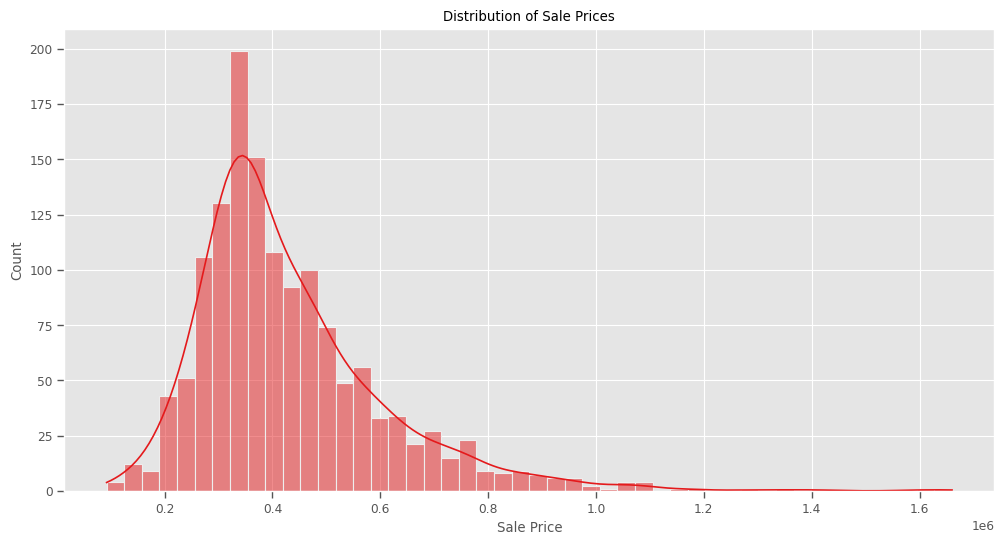

In [351]:
# Distribution of sale prices
plt.figure(figsize=(12, 6))
sns.histplot(df['Sale Price'], kde=True)
plt.title('Distribution of Sale Prices')

##### Sale Price by Property Type
Detached homes command the highest median price, while also having the largest spread. Bungalow and Terraced are among the worst performers by price.

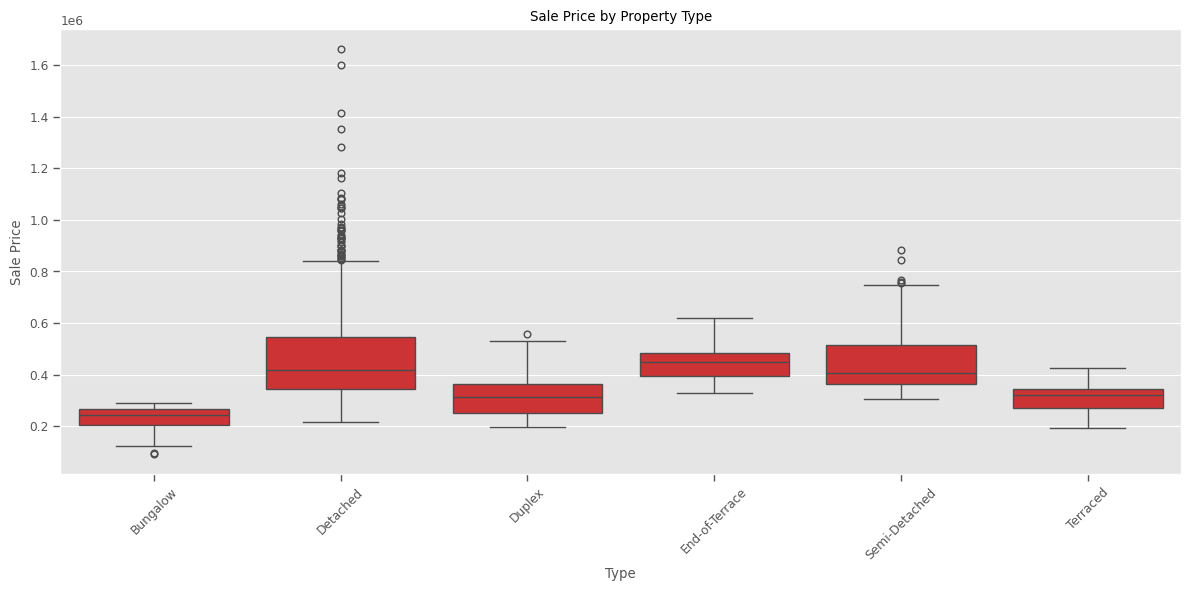

In [352]:
# Price by property type
plt.figure(figsize=(12, 6))
sns.boxplot(x='Type', y='Sale Price', data=df)
plt.title('Sale Price by Property Type')
plt.xticks(rotation=45)
plt.tight_layout()

##### Average Sale Price Over Time
The average sale price seem to be acyclical, however breaking the sales price down by features like location might show more cyclicality, there is a slight upward trend in prices over time.

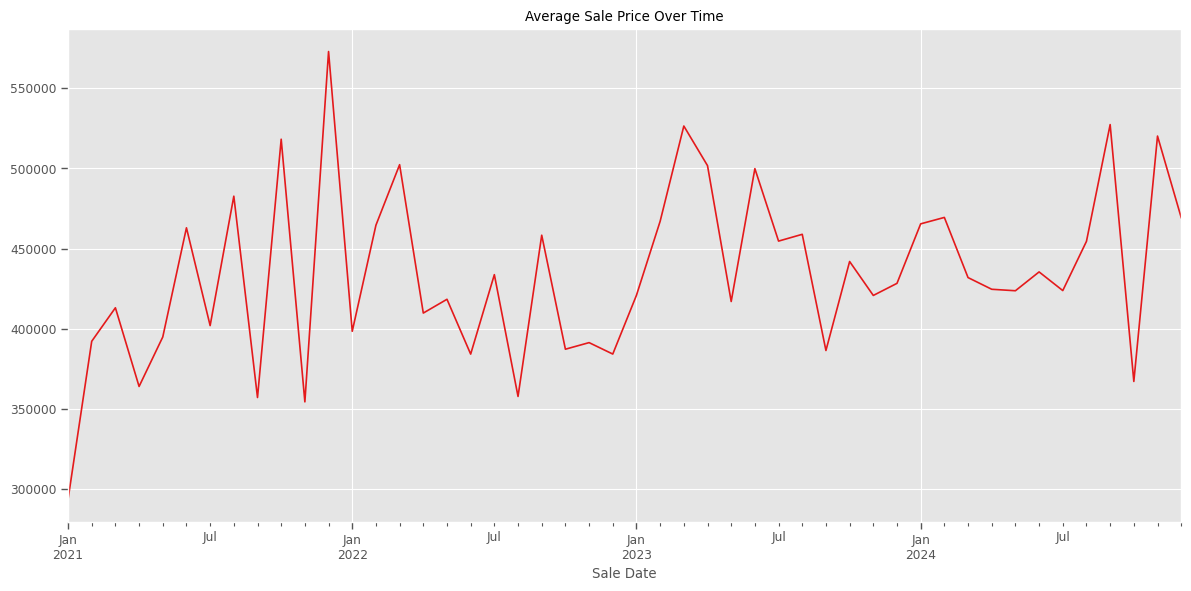

In [353]:
# Price over time
plt.figure(figsize=(12, 6))
df.set_index('Sale Date')['Sale Price'].resample('M').mean().plot()
plt.title('Average Sale Price Over Time')
plt.tight_layout()

##### Average Sale Price Over Time by Property Type
This visualisation matches expectations, although it seems like due to the mean being used it is much less stable than one might expect. The Semi-Detached actually manages to overtake Detached some times due to rapid spikes. This could be due to Semi-Detached from nicer neighborhoods being sold around the same time while detached houses are more stable across neighborhoods.

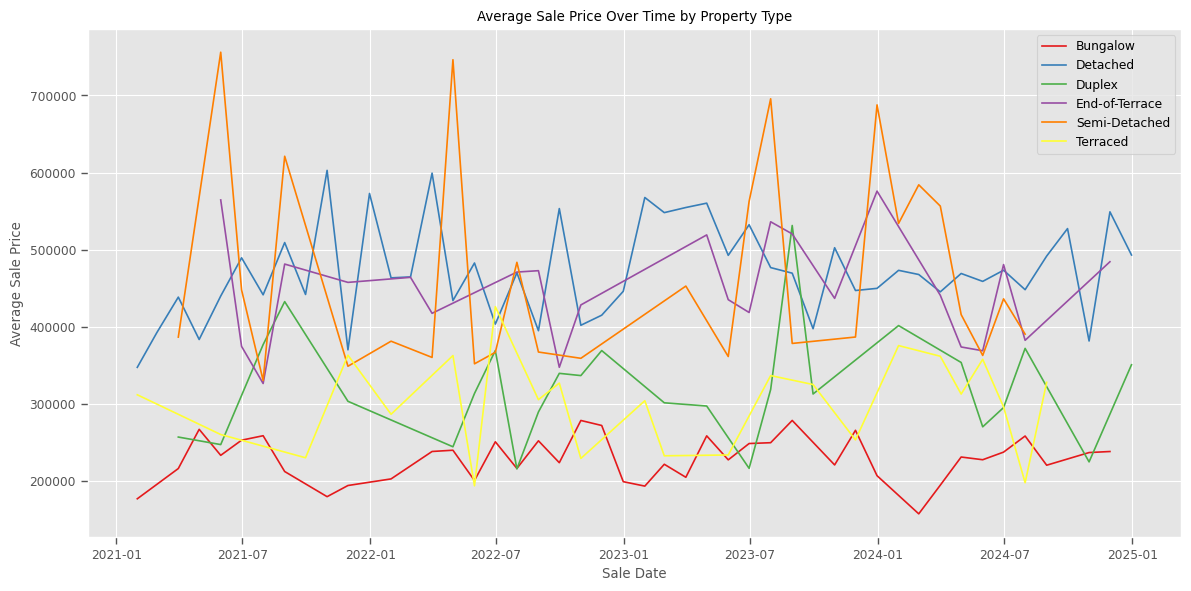

In [354]:
df_grouped = df.groupby(['Type', pd.Grouper(key='Sale Date', freq='M')])['Sale Price'].mean().reset_index()

plt.figure(figsize=(12,6))
sns.lineplot(data=df_grouped, x='Sale Date', y='Sale Price', hue='Type')
plt.title('Average Sale Price Over Time by Property Type')
plt.xlabel('Sale Date')
plt.ylabel('Average Sale Price')
plt.legend()
plt.tight_layout()

##### Average Sale Price Over Time by Property Location
This breakdown aligns much more with expectations, overall the trends are much more stable. The large fluctuations in the nicest neighborhood, Avoca, spike suddenly when the nicest houses in this neighborhood are put on the market. This also aligns well in timing where the average price decreases around the increases in price for Semi-Detached property types. This could also be a coincidence. It would be worth checking specific datapoints to verify this.

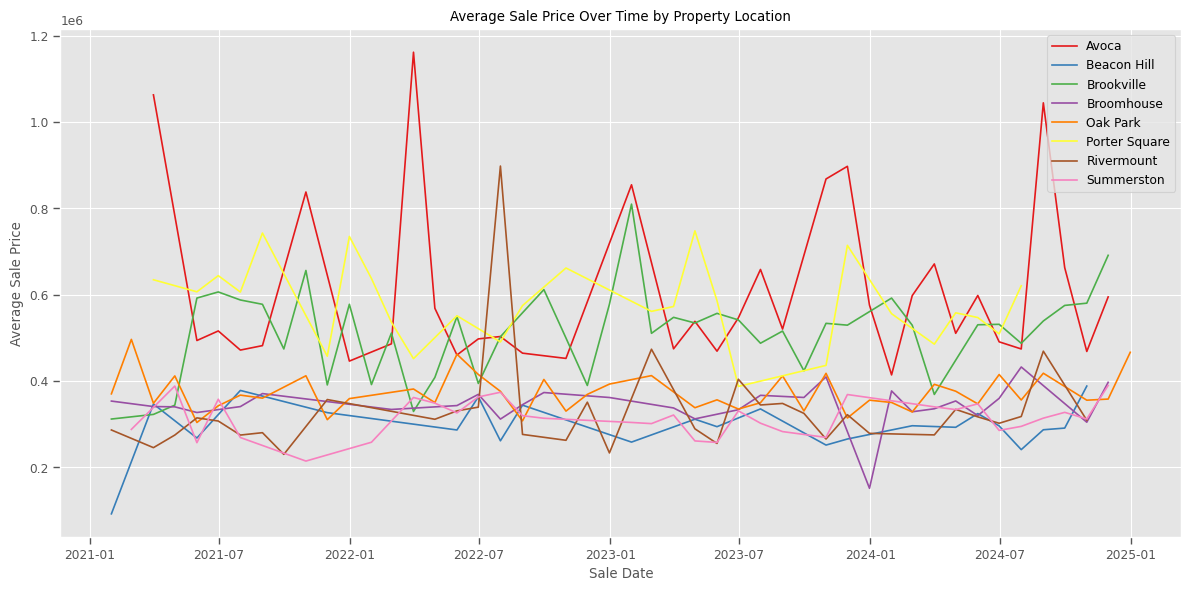

In [355]:
df_grouped = df.groupby(['Property Location', pd.Grouper(key='Sale Date', freq='M')])['Sale Price'].median().reset_index()

plt.figure(figsize=(12,6))
sns.lineplot(data=df_grouped, x='Sale Date', y='Sale Price', hue='Property Location')
plt.title('Average Sale Price Over Time by Property Location')
plt.xlabel('Sale Date')
plt.ylabel('Average Sale Price')
plt.legend()
plt.tight_layout()

##### Sales Price Distribtuion for Property Locations
This aligns with expectations, Avoca has the highest proportion in larger sale prices. It is actually unexpected that Avoca has a larger number of homes on the market than expected. 

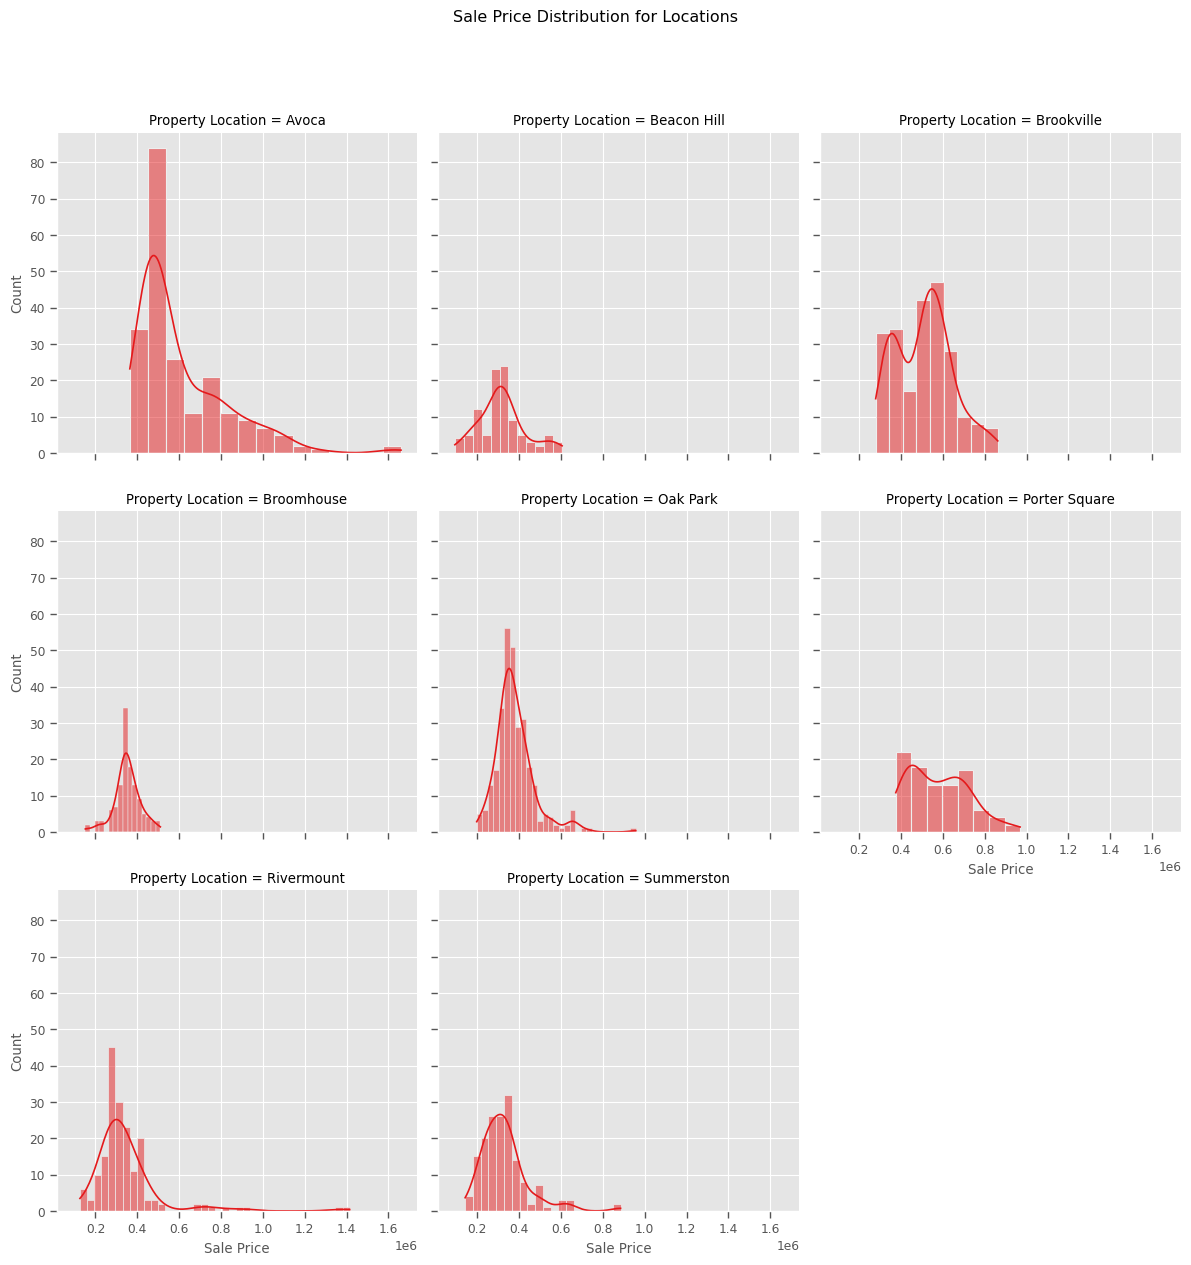

In [356]:
g = sns.FacetGrid(df, col='Property Location', col_wrap=3, height=4)
g.map(sns.histplot, 'Sale Price', kde=True)
g.fig.suptitle('Sale Price Distribution for Locations', y = 1.05)
g.set_axis_labels('Sale Price', 'Count')
plt.tight_layout()

##### Sale Price vs Building Age by Property Location
The building age has significant impacts on trends, as can be seen across most neighborhoods. Avoca, the highest price neighborhood is mostly populated by new builds, along with other neighborhoods that could be rising in construction number. It is interesting to see the old age of ouses in Rivermount, and the large price that some of these houses have, even though most remain lower in price. This is where additional data like square footage or number of acres would be more telling.

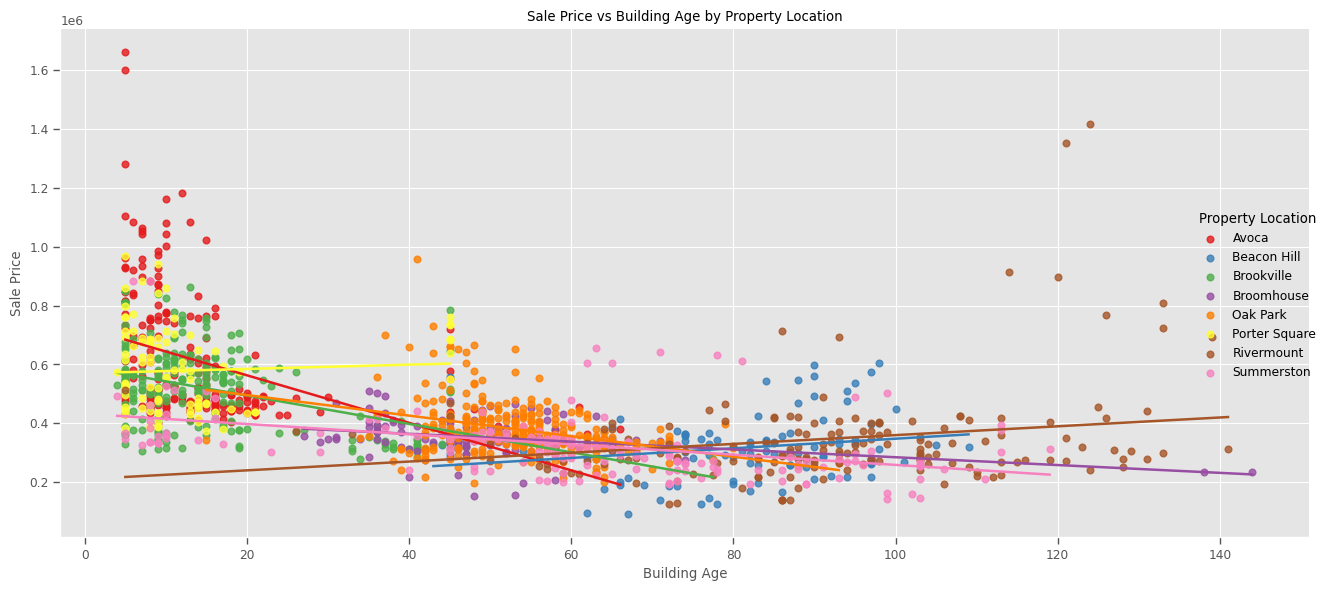

In [357]:
g = sns.lmplot(data=df, x='Building Age', y='Sale Price', hue='Property Location', height=6, aspect=2, ci=None)
plt.title('Sale Price vs Building Age by Property Location')
plt.xlabel('Building Age')
plt.ylabel('Sale Price')
plt.tight_layout()

##### Sale Price vs Building Age by Property Type
Most properties are detached, with a slightly declining trend as building age increases. Bungalow and Terraced actually remain incredibly stable regardless of building age, remaining the most stable across the board.

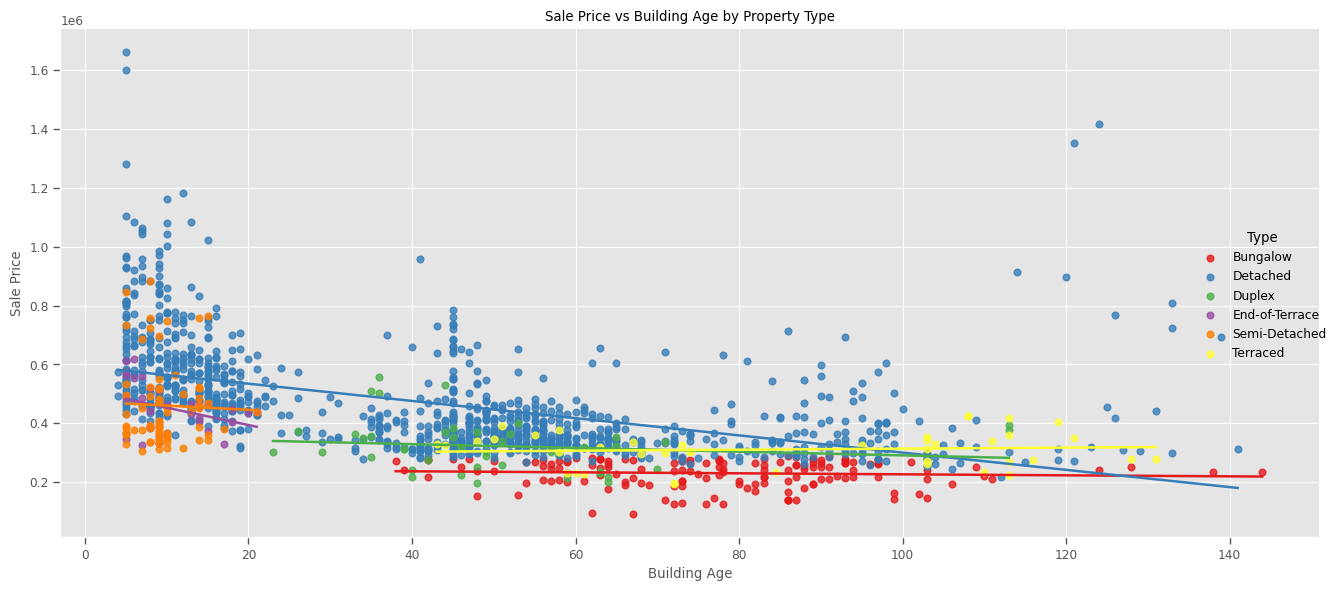

In [358]:
g = sns.lmplot(data=df, x='Building Age', y='Sale Price', hue='Type', height=6, aspect=2, ci=None)
plt.title('Sale Price vs Building Age by Property Type')
plt.xlabel('Building Age')
plt.ylabel('Sale Price')
plt.tight_layout()

##### Average Price per Room by Property Type
This is an interesting chart due to the implications that Semi-Detached provide the worst cost to number of rooms ratio. It is essentially a pseudo square footage cost, with Semi-Detached being the worst value and Duplex being the best value.

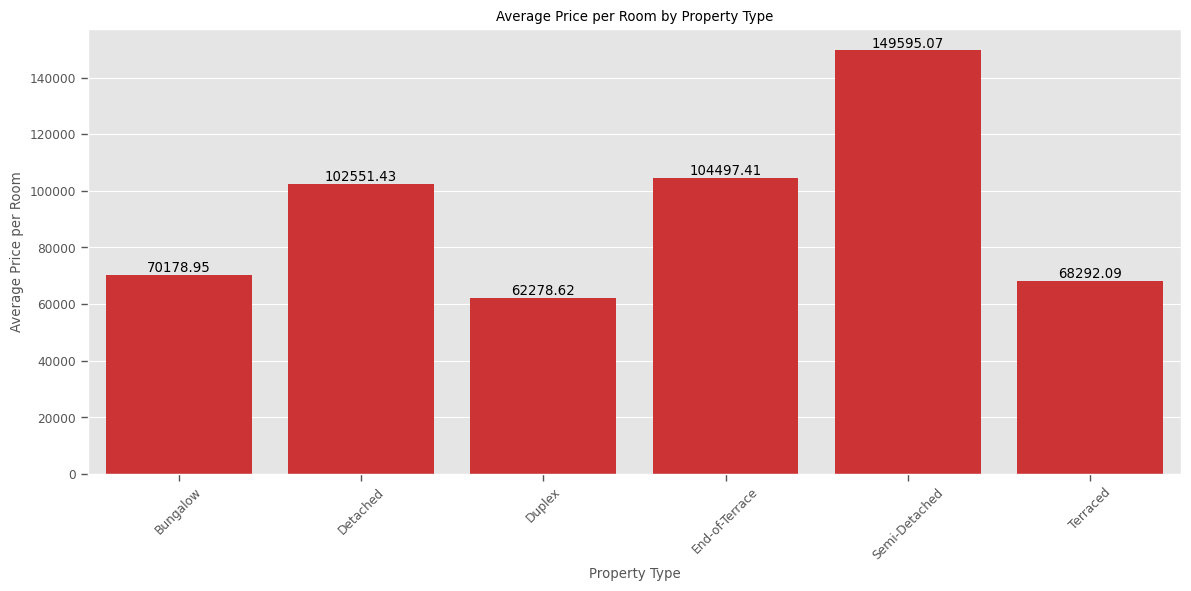

In [359]:
avg_price_per_room = df.groupby('Type')['Price per Room'].mean().reset_index()

# Plot
plt.figure(figsize=(12, 6))
sns.barplot(data=avg_price_per_room, x='Type', y='Price per Room')
plt.title('Average Price per Room by Property Type')
plt.xlabel('Property Type')
plt.ylabel('Average Price per Room')
plt.xticks(rotation=45)

# Add annotations
for i, v in enumerate(avg_price_per_room['Price per Room']):
    plt.text(i, v, f'{v:.2f}', ha='center', va='bottom')

plt.tight_layout()

##### Average Price per Room by Property Location
This is essentially the same as what you would expect from the neighborhood median prices, where people are paying premiums in Avoca with newer builds in a nicer area. It is similar to the cost of other high COL neighborhoods, while the lower cost neighborhoods are relatively stable in price per room, although housing costs do differ due to the different types that can be found across these locations.

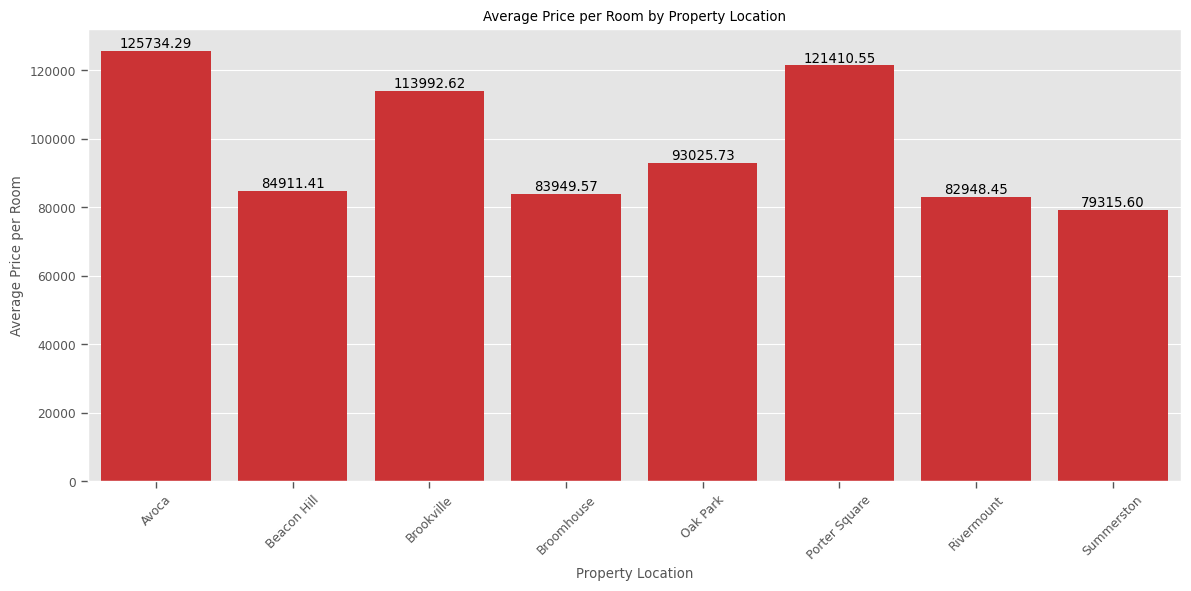

In [360]:
avg_price_per_room = df.groupby('Property Location')['Price per Room'].mean().reset_index()

# Plot
plt.figure(figsize=(12, 6))
sns.barplot(data=avg_price_per_room, x='Property Location', y='Price per Room')
plt.title('Average Price per Room by Property Location')
plt.xlabel('Property Location')
plt.ylabel('Average Price per Room')
plt.xticks(rotation=45)

# Add annotations
for i, v in enumerate(avg_price_per_room['Price per Room']):
    plt.text(i, v, f'{v:.2f}', ha='center', va='bottom')

plt.tight_layout()

##### Sale Price Distribution by Property Style
Style 1.5 is quite basic, with a relatively compact distribution, however styles 1 and 2 are interestingly skewed strongly. Although They have similar medians, they make up a large proportion of higher priced homes. It could be that the style range inside of 1 and 2 have large variations in things like square footage, acres of land, or other factors like neighborhoods or access to things like a garden.

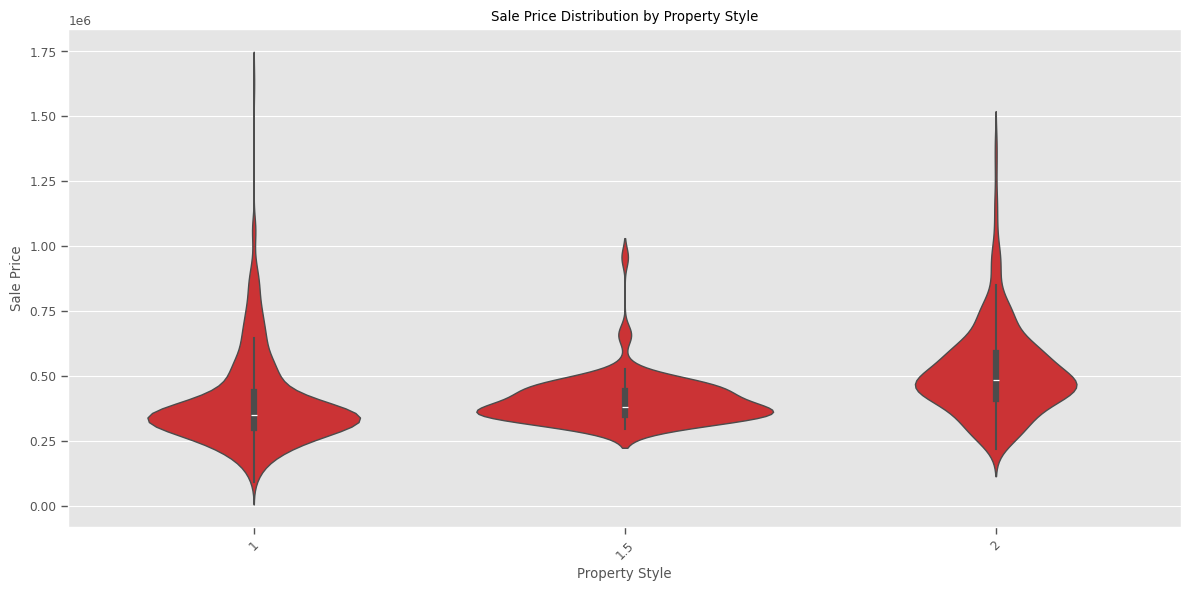

In [361]:
plt.figure(figsize=(12,6))
sns.violinplot(data=df, x='Style', y='Sale Price')
plt.title('Sale Price Distribution by Property Style')
plt.xlabel('Property Style')
plt.ylabel('Sale Price')
plt.xticks(rotation=45)
plt.tight_layout()

## Correlation Analysis
Performs correlation analysis between features and sale price
1. Converts categorical vlaues to numeric for correlation calculation
2. Calculates correlation matrix
3. Displays sorted correlations with sale price

This helps identify the features most strongly associated with property prices.

The Price vs Location feature has the strongest correlation, with 0.79. This is within expectations as the average price in nicer neighborhoods is expected to be higher than the average price of less nice neighborhoods. Correlations like luxury are a slight leakage, as they are based on the quantile price of the property itself, so it shares high collinearity with the price. Features like the year sold have little signifance on price, this makes sense due to seeing a noisy graph of sales prices over time.

In [362]:
# Convert categorical variables to numeric for correlation
df_corr = df.copy()
categorical_cols = df.select_dtypes(include=['object', 'bool', 'category']).columns
for col in categorical_cols:
    if col in df_corr.columns:
        df_corr[col] = pd.factorize(df_corr[col])[0]

# Calculate correlation matrix
corr_matrix = df_corr.corr()
print("Correlation with Sale Price:")
print(corr_matrix['Sale Price'].sort_values(ascending=False))


Correlation with Sale Price:
Sale Price                   1.000000
Price vs Location Median     0.792948
Luxury?                      0.785227
Price per Year Old           0.762697
Price per Room               0.760279
Price per Bedroom            0.707576
Price Percentile             0.657793
Location Median Price        0.580260
Bathrooms                    0.535449
Year Built                   0.532713
Bedroom x Bathroom           0.481863
Total Rooms                  0.444872
Property Location            0.386180
Recent Build?                0.290507
Style                        0.271575
Bedrooms                     0.235981
Price 30 Day MA              0.217695
Price 90 Day MA              0.095656
Sale Year                    0.042439
Sale Date                    0.041519
Days Since First Sale        0.041519
Sale Day of Week             0.032940
Sale Month                  -0.004557
Sale Week of Year           -0.006166
Sale Quarter                -0.017231
First Time Buyer     

## Property Type Analysis
Creates visualisations showing:
1. Distribution of property types in the dataset
2. Average price by Property Type

This will only be done for a few categories because it becomes redundant otherwise.

##### Distribution of Property Types
The vast majority of houses are of the Detached Type, with Terraces and End-of-Terraces being the lowest proportion of houses sold.

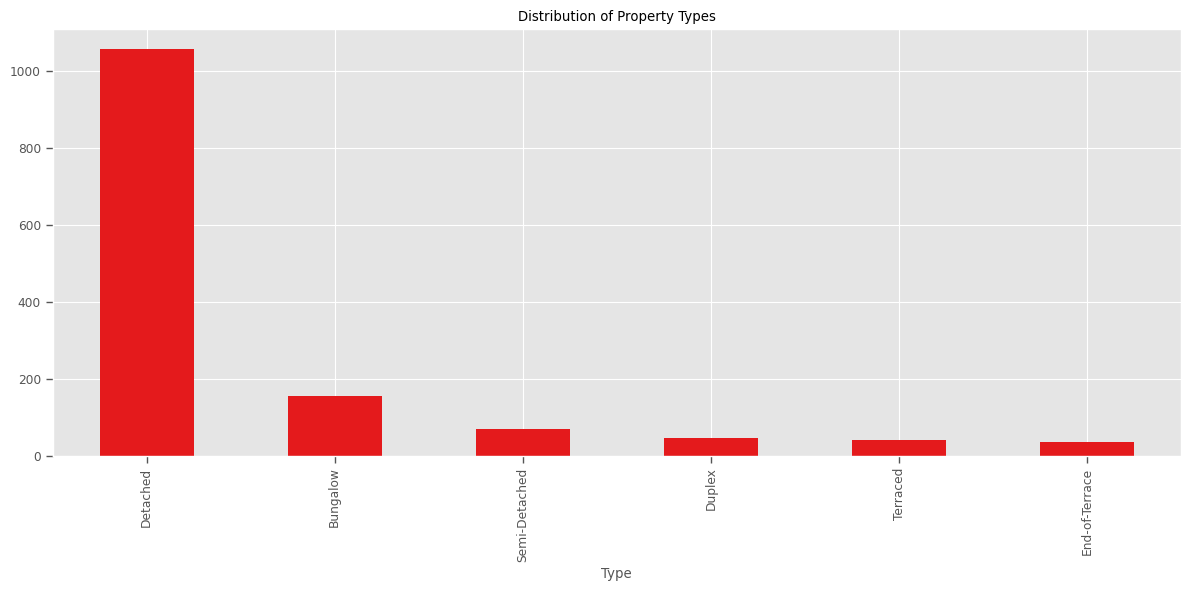

In [363]:
# Distribution of property types
plt.figure(figsize=(12, 6))
df['Type'].value_counts().plot(kind='bar')
plt.title('Distribution of Property Types')
plt.tight_layout()

Text(0.5, 1.0, 'Average Price by Property Type')

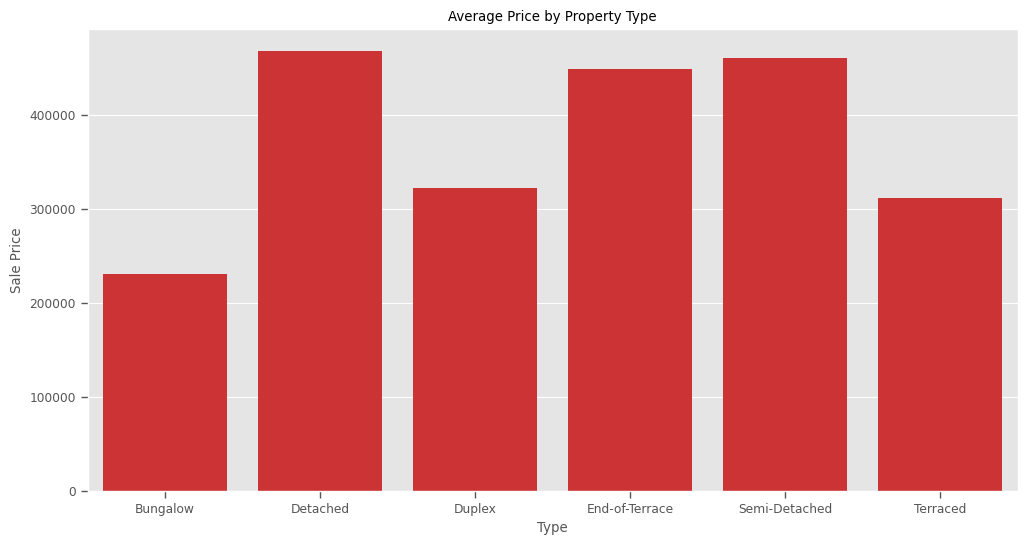

In [364]:
# Average Price by Property type
plt.figure(figsize=(12,6))
property_price = df.groupby('Type')['Sale Price'].mean().reset_index()
sns.barplot(x='Type', y = 'Sale Price', data=property_price)
plt.title("Average Price by Property Type")

## Bedroom Number Analysis
Creates visualisations showing:
1. Distribution of bedroom numbers in the dataset
2. Average price by number of bedrooms
3. Distribution of bedroom prices with density.
4. Box Plot of Sale Price by Number of Bedrooms

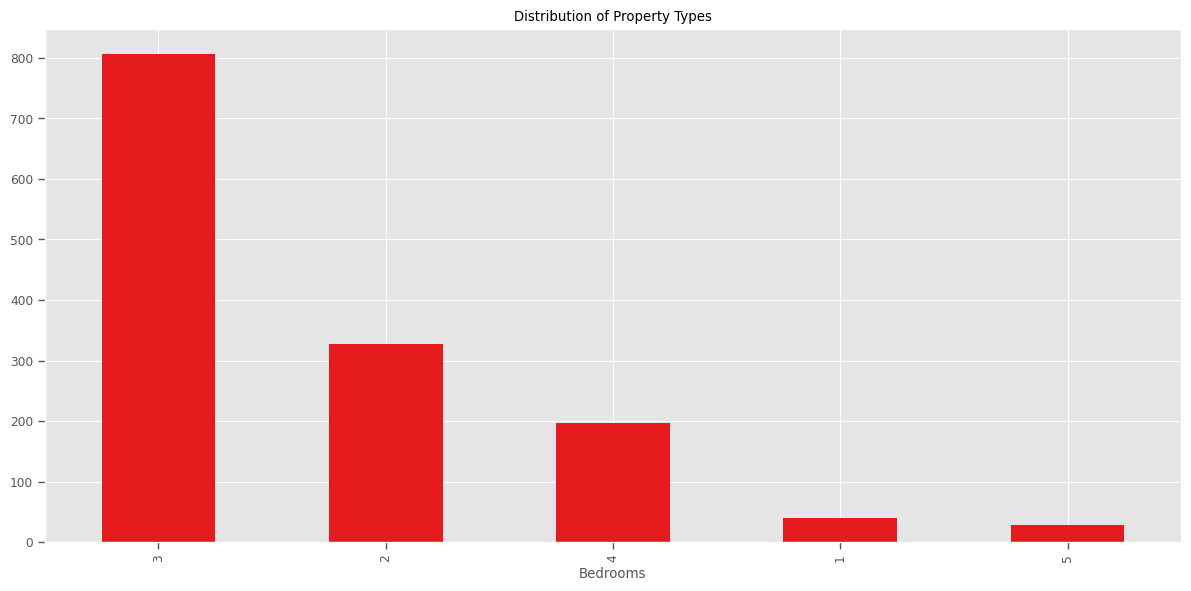

In [365]:
# Distribution of property types
plt.figure(figsize=(12, 6))
df['Bedrooms'].value_counts().plot(kind='bar')
plt.title('Distribution of Property Types')
plt.tight_layout()

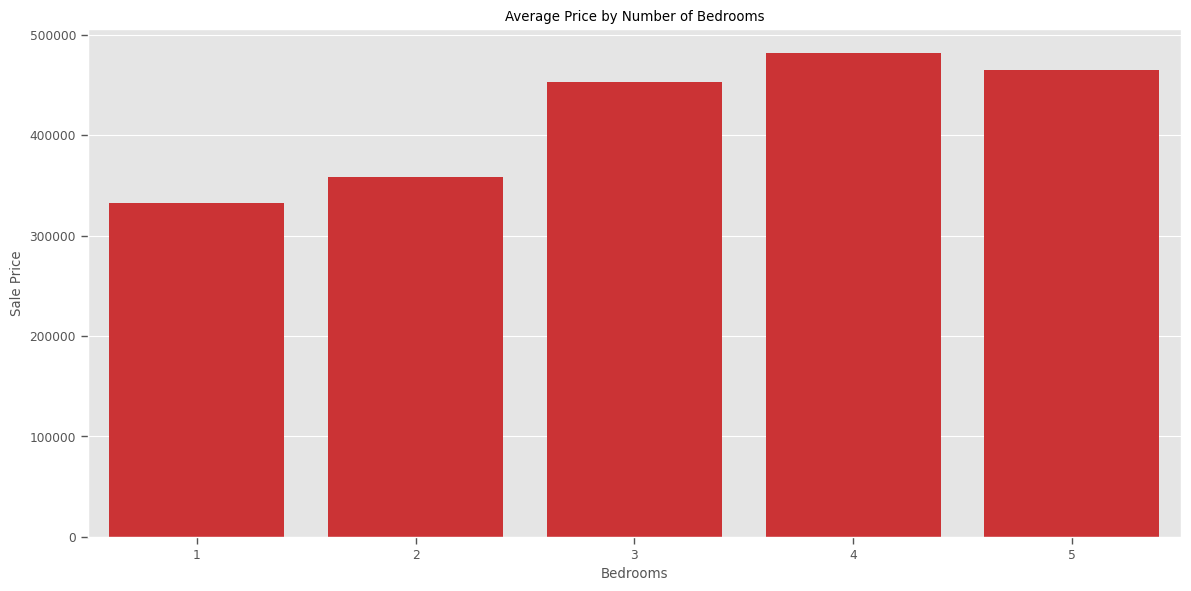

In [366]:
# Average price by number of bedrooms
plt.figure(figsize=(12, 6))
bedroom_price = df.groupby('Bedrooms')['Sale Price'].mean().reset_index()
sns.barplot(x='Bedrooms', y='Sale Price', data=bedroom_price)
plt.title('Average Price by Number of Bedrooms')
plt.tight_layout()

##### Price Distribution by Number of Bedrooms
Interstingly, most follow a skewed normal or beta distribution. However, the 5-bedrooms are clearly quite bimodal. Meaning that there could be substantial differention on five-bedroom houses across different neighborhoods or other factors.

Text(0, 0.5, 'Density')

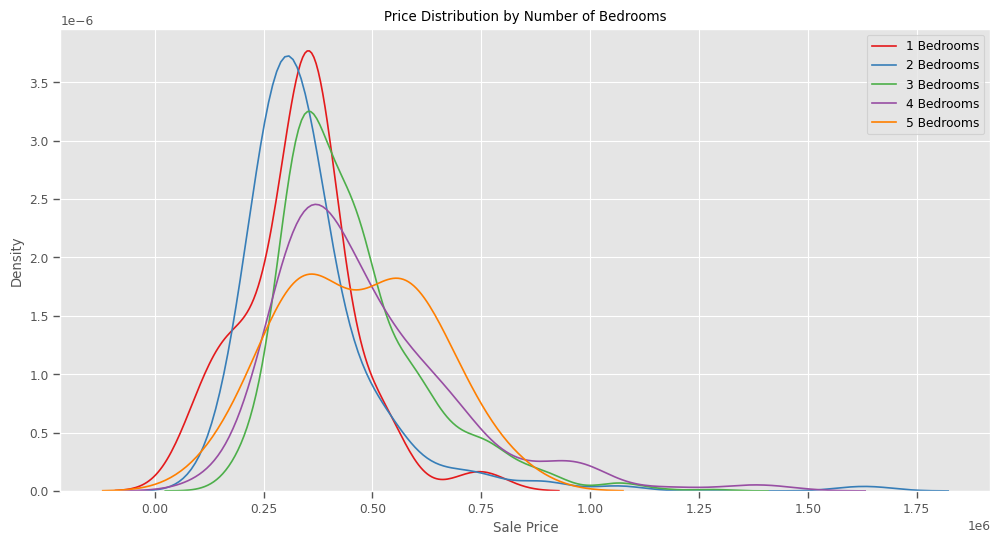

In [367]:
plt.figure(figsize=(12,6))
for bed in sorted(df['Bedrooms'].unique()):
    sns.kdeplot(df[df['Bedrooms'] == bed]['Sale Price'], label=f'{bed} Bedrooms')
plt.title('Price Distribution by Number of Bedrooms')
plt.xlabel('Sale Price')
plt.legend()
plt.ylabel('Density')

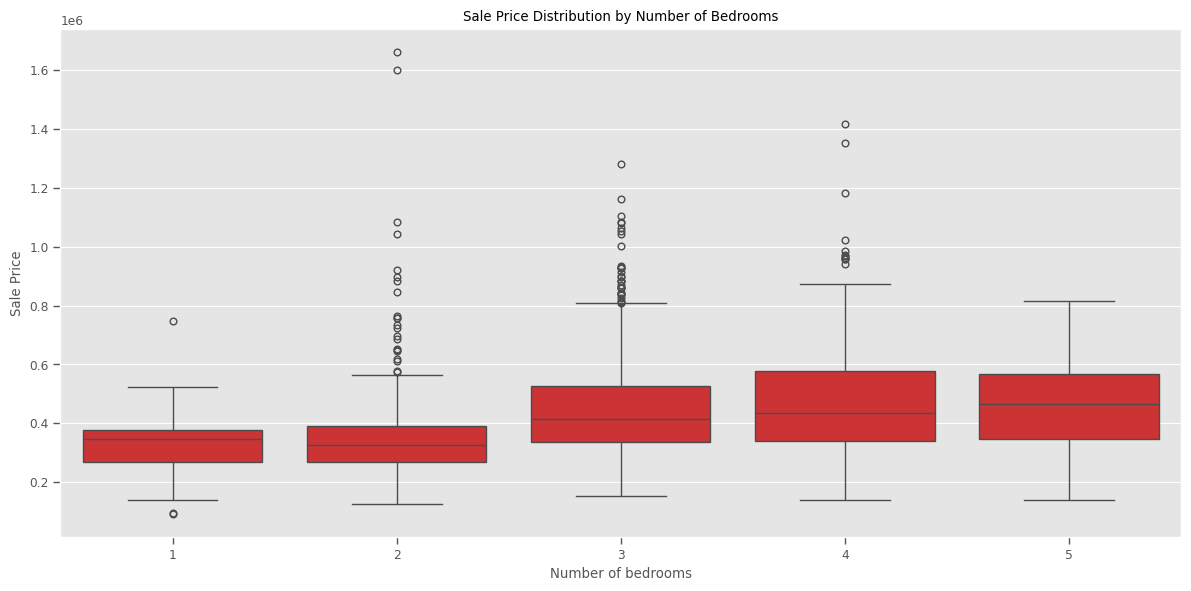

In [368]:
plt.figure(figsize=(12,6))
sns.boxplot(data=df, x='Bedrooms', y='Sale Price')
plt.title('Sale Price Distribution by Number of Bedrooms')
plt.xlabel('Number of bedrooms')
plt.ylabel('Sale Price')
plt.tight_layout()

## Price by Example Features
1. List some features for reference
2. Create multiple boxplots showing how various features vary with price
3. Box Plot of Sale Price by Luxury Status and Recent Build

Facet grids could also be used.

##### Some Unseen Features Breakdown by Price
The different features broken down by price can be seen, some interesting ones like Price by Garden have a large number of outliers.

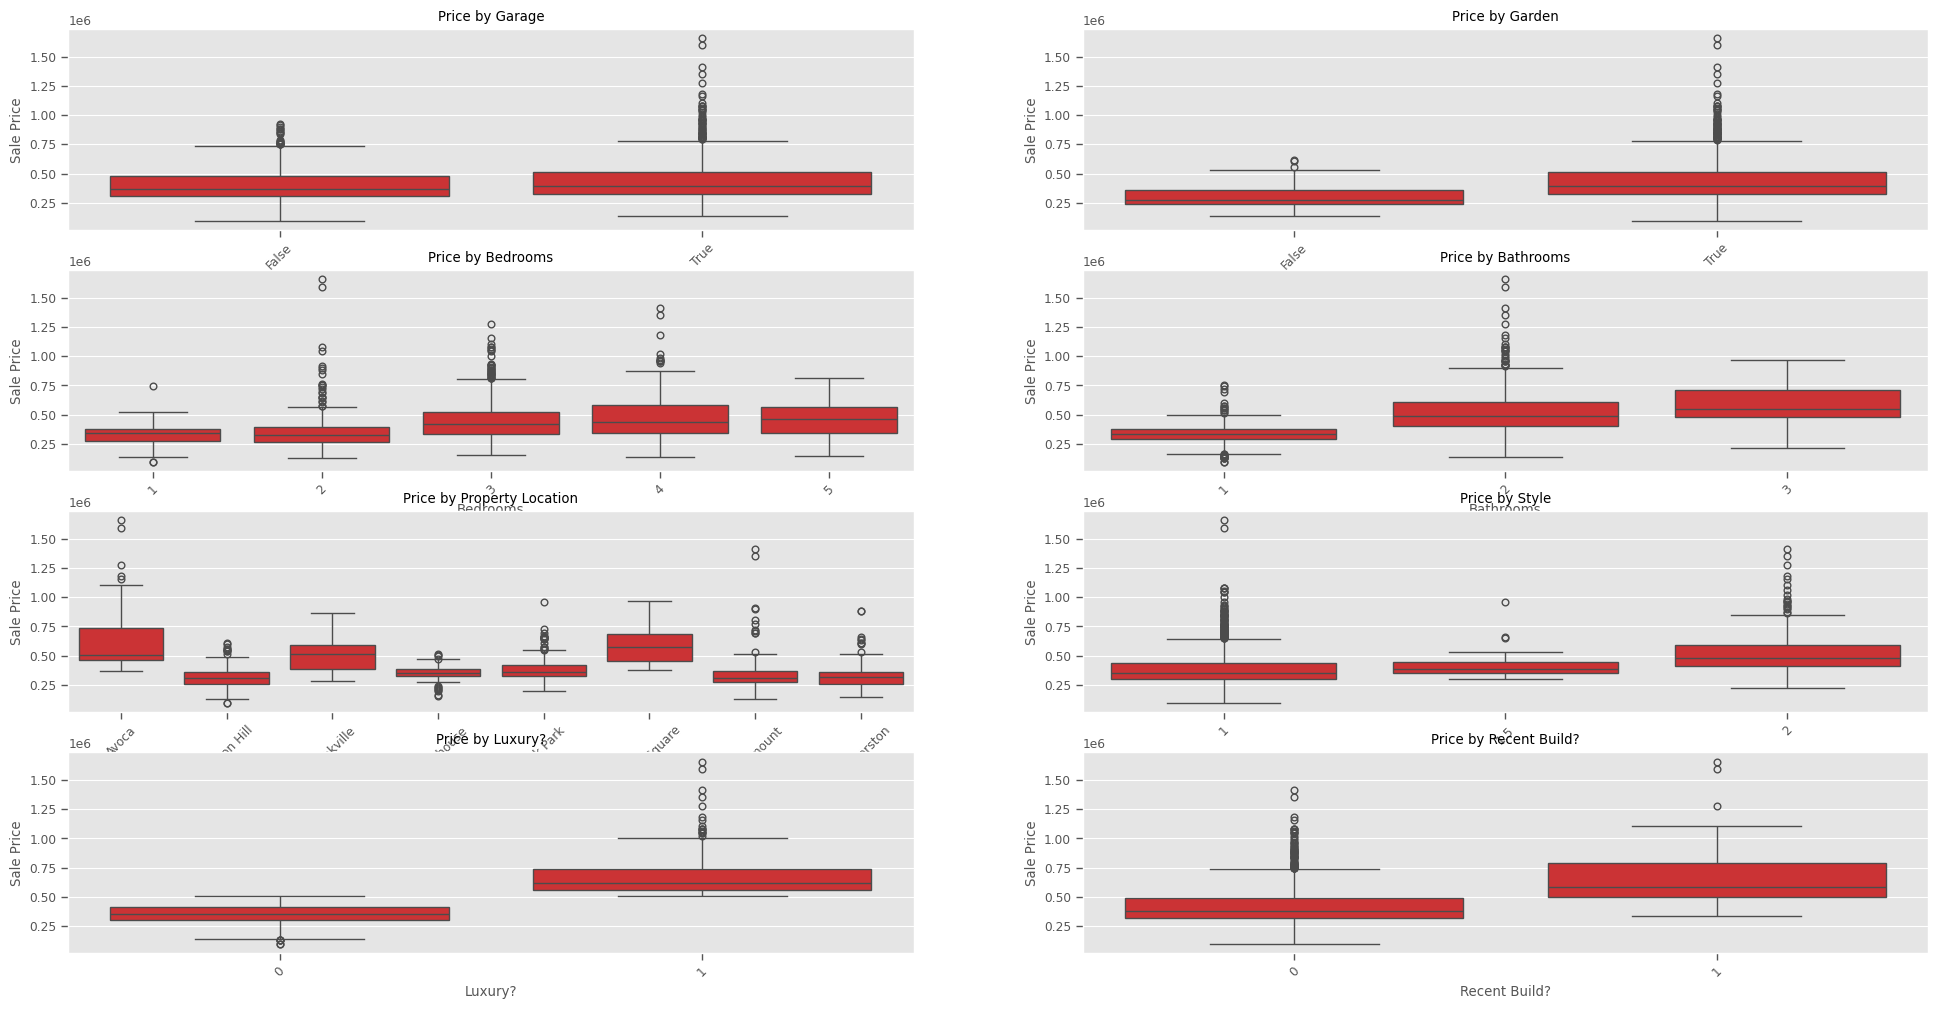

<Figure size 640x480 with 0 Axes>

In [369]:
# Impact of some features on price
features = ['Garage', 'Garden', 'Bedrooms', 'Bathrooms', 'Property Location', 'Style', 'Luxury?', 'Recent Build?' ]
fig, axes = plt.subplots(nrows=4, ncols=2, figsize=(24, 12))

for i, feature in enumerate(features):
    if feature in df.columns:
        rows = i // 2
        cols = i % 2
        sns.boxplot(x=feature, y='Sale Price', data=df, ax=axes[rows, cols])
        axes[rows, cols].set_title(f'Price by {feature}')
        axes[rows, cols].tick_params(axis='x', rotation=45)

plt.show()
plt.tight_layout()

##### Luxury vs. Older Buildings
Luxury properties, most likely to be newer builds command a substantial price increase over older builds across the board, which has been seen in previous visualisations.

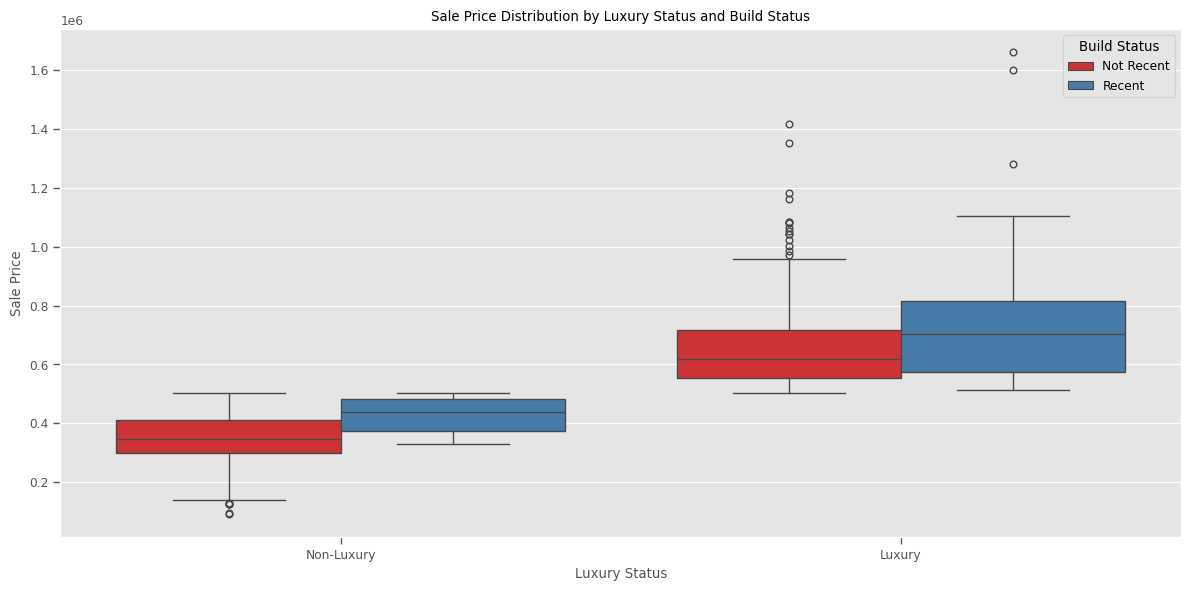

In [370]:
df['Luxury Status'] = df['Luxury?'].map({0: 'Non-Luxury', 1: 'Luxury'})
df['Build Status'] = df['Recent Build?'].map({0: 'Not Recent', 1: 'Recent'})

# Create box plot
plt.figure(figsize=(12, 6))
sns.boxplot(data=df, x='Luxury Status', y='Sale Price', hue='Build Status')
plt.title('Sale Price Distribution by Luxury Status and Build Status')
plt.xlabel('Luxury Status')
plt.ylabel('Sale Price')
plt.legend(title='Build Status')
plt.tight_layout()

## Year Built Analysis
Generate a scatter plot and decade bar chart showing the relationship between construction year and price, remember missing values, although minor in number, use imputation.

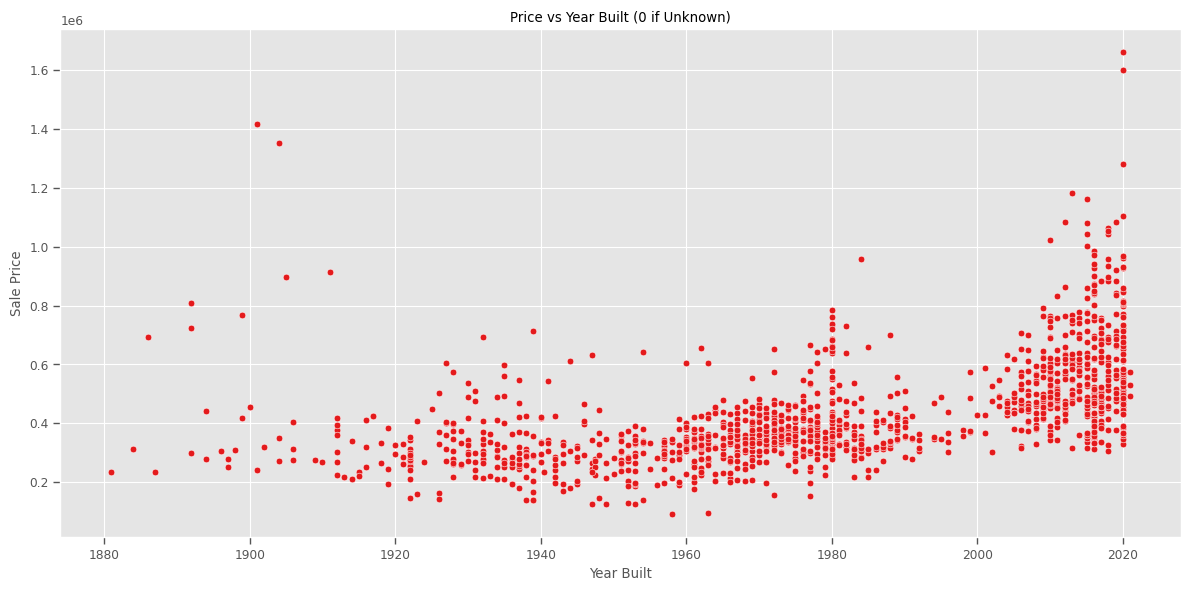

In [371]:
# Year built analysis
if 'Year Built' in df.columns:
    plt.figure(figsize=(12, 6))
    sns.scatterplot(x='Year Built', y='Sale Price', data=df)
    plt.title('Price vs Year Built (0 if Unknown)')
    plt.tight_layout()


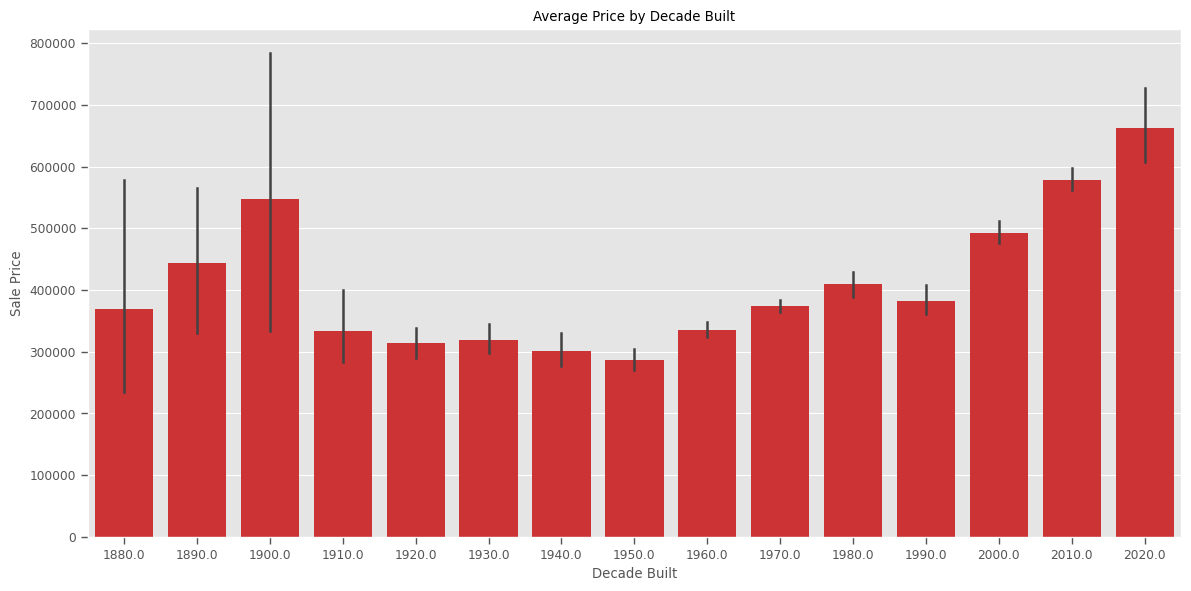

In [372]:
# Year built analysis
if 'Year Built' in df.columns:    
    # Decade analysis
    df['Decade Built'] = (df['Year Built'] // 10) * 10
    plt.figure(figsize=(12, 6))
    decade_price = df.groupby('Decade Built')['Sale Price'].mean().reset_index()
    decade_price = df[df['Decade Built'] != 0]
    sns.barplot(x='Decade Built', y='Sale Price', data=decade_price)
    plt.title('Average Price by Decade Built')
    plt.tight_layout()

## Location Analysis
Creates a bar chart showing average prices for the given locations, highlighting geogrpahic price variations. It is initially assumed to be the biggest indicator of price, after the three Ls of buying a house. Location, Location, Location.

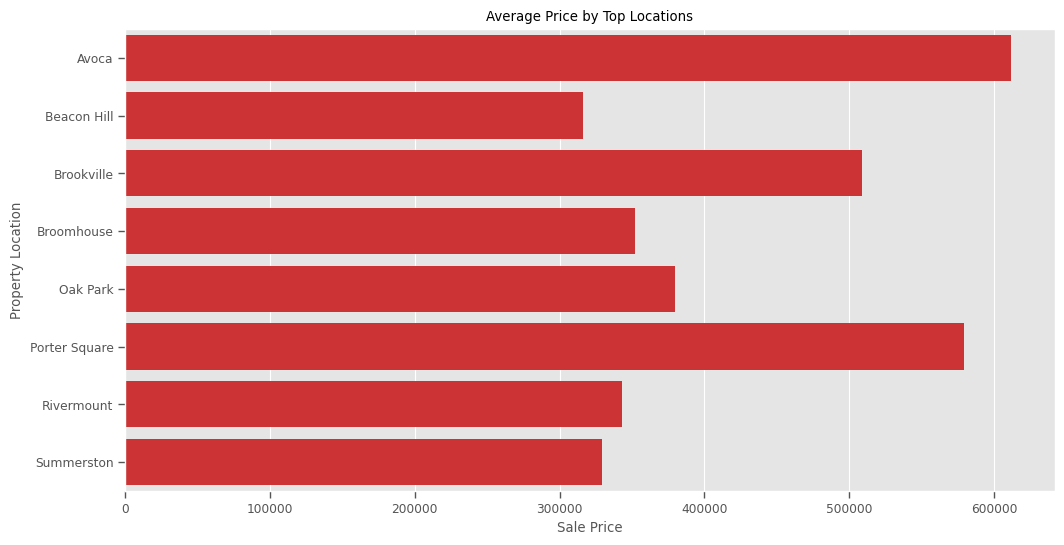

In [373]:
# Location analysis
if 'Property Location' in df.columns:
    plt.figure(figsize=(12, 6))
    location_price = df.groupby('Property Location')['Sale Price'].mean().sort_values(ascending=False).reset_index()
    top_locations = location_price.head(15)
    sns.barplot(x='Sale Price', y='Property Location', data=top_locations)
    plt.title('Average Price by Top Locations')

## ANOVA Tests
Performs ANOVA tests to statistically validate whether categorical features (like property type and location) have significant impacts on price.

In [374]:
# ANOVA test for categorical variables impact on price
categorical_features = df.select_dtypes(include='category').columns.tolist()
for feature in categorical_features:
    if feature in df.columns:
        # Create groups for ANOVA
        groups = []
        for name, group in df.dropna(subset=[feature, 'Sale Price']).groupby(feature, observed=True):
            groups.append(group['Sale Price'].values)
        
        if len(groups) >= 2:  # Need at least 2 groups for ANOVA
            f_stat, p_value = stats.f_oneway(*groups)
            print(f"ANOVA test for {feature}: F={f_stat:.4f}, p={p_value:.4f}")
            if p_value < 0.05:
                print(f"  {feature} has a statistically significant impact on price")
            else:
                print(f"  No significant impact of {feature} on price")



ANOVA test for Property Location: F=118.6375, p=0.0000
  Property Location has a statistically significant impact on price
ANOVA test for Garden: F=43.1155, p=0.0000
  Garden has a statistically significant impact on price
ANOVA test for Garage: F=16.6695, p=0.0000
  Garage has a statistically significant impact on price
ANOVA test for Type: F=70.9963, p=0.0000
  Type has a statistically significant impact on price
ANOVA test for Style: F=73.1666, p=0.0000
  Style has a statistically significant impact on price


## Basic Model Training
1. Prepares data for modelling by splitting features and target
2. Sets up preprocessing pipeline with one-hot encoding for categorical variables
3. Trains a baseline linear regression model
4. Evaluates model performance with RMSE and Pearons R
5. Creates and displays additional engineered features

In [375]:
# Prepare data for modeling
X = df.drop(['Sale Price'], axis=1)
y = df['Sale Price']

# Identify categorical columns
cat_cols = X.select_dtypes(include=['category', 'bool', 'object']).columns.tolist()
num_cols = X.select_dtypes(include=['int64', 'float64']).columns.tolist()

# Drop non-useful columns for prediction
cols_to_drop = []
if 'Sale Date' in X.columns:
    cols_to_drop.append('Sale Date')
X = X.drop(cols_to_drop, axis=1)

# Update categorical and numerical columns
cat_cols = [col for col in cat_cols if col not in cols_to_drop]
num_cols = [col for col in num_cols if col not in cols_to_drop]

# Handle missing values
X = X.fillna({col: X[col].mode()[0] for col in cat_cols})
X = X.fillna({col: X[col].median() for col in num_cols})

try:
    # Create preprocessor
    preprocessor = ColumnTransformer(
        transformers=[
            ('num', 'passthrough', num_cols),
            ('cat', OneHotEncoder(handle_unknown='ignore'), cat_cols)
        ])

    # Create and train model
    model = Pipeline(steps=[
        ('preprocessor', preprocessor),
        ('regressor', LinearRegression())
    ])

    # Split data
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=1)
    
    # Train model
    model.fit(X_train, y_train)
    
    # Evaluate model
    y_pred = model.predict(X_test)
    rmse = root_mean_squared_error(y_test, y_pred)
    r2 = r2_score(y_test, y_pred)
    
    print(f"Model performance:")
    print(f"  Mean Absolute Error: ${rmse:.2f}")
    print(f"  R² Score: {r2:.4f}")
    
    if r2 >= 0.7:
        print("  Good model fit! The model explains a significant portion of price variability.")
    elif r2 >= 0.5:
        print("  Moderate model fit. The model explains some price variability but could be improved.")
    else:
        print("  Poor model fit. Consider using more features or a different model.")
except Exception as e:
    print(f"Error in model building: {e}")

Model performance:
  Mean Absolute Error: $18896.90
  R² Score: 0.9902
  Good model fit! The model explains a significant portion of price variability.


## XGBoost and Random Forest Models
1. Trains XGBoost and Random Forest Regressors with preprocessing pipelines
2. Evaluates model performance
3. Identifies and visualises the most important features for each model

In [376]:
# Prepare data for modeling
X = df.drop(['Sale Price', 'Sale Date'], axis=1)
y = df['Sale Price']

# Identify categorical and numerical columns
cat_cols = X.select_dtypes(include=['category', 'bool']).columns.tolist()
num_cols = X.select_dtypes(include=['int64', 'float64']).columns.tolist()

# Create preprocessor
preprocessor = ColumnTransformer(
    transformers=[
        ('num', 'passthrough', num_cols),
        ('cat', OneHotEncoder(handle_unknown='ignore'), cat_cols)
    ])

# Split data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Create and train XGBoost model
xgb_reg = xgb.XGBRegressor(
    n_estimators=100,
    learning_rate=0.1,
    max_depth=5,
    min_child_weight=1,
    subsample=0.8,
    colsample_bytree=0.8,
    objective='reg:squarederror',
    random_state=42
)

# Create pipeline
xgb_pipe = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('regressor', xgb_reg)
])

# Train model
xgb_pipe.fit(X_train, y_train)

# Evaluate model
y_pred_xgb = xgb_pipe.predict(X_test)
rmse_xgb = np.sqrt(mean_squared_error(y_test, y_pred_xgb))
r2_xgb = r2_score(y_test, y_pred_xgb)

print(f"XGBoost Model Performance:")
print(f"  RMSE: ${rmse_xgb:.2f}")
print(f"  R² Score: {r2_xgb:.4f}")

if r2_xgb >= 0.7:
    print("  Good model fit! The model explains a significant portion of price variability.")
elif r2_xgb >= 0.5:
    print("  Moderate model fit. The model explains some price variability but could be improved.")
else:
    print("  Poor model fit. Consider using more features or a different model.")

XGBoost Model Performance:
  RMSE: $17684.23
  R² Score: 0.9894
  Good model fit! The model explains a significant portion of price variability.


In [377]:
# Get feature importance from the model
feature_importance = xgb_pipe.named_steps['regressor'].feature_importances_

# Get feature names after preprocessing
preprocessor = xgb_pipe.named_steps['preprocessor']
cat_features = preprocessor.transformers_[1][1].get_feature_names_out(cat_cols)
all_features = np.concatenate([num_cols, cat_features])

# Create importance dataframe
importance_df = pd.DataFrame({
    'Feature': all_features,
    'Importance': feature_importance
}).sort_values('Importance', ascending=False)

importance_df.head()

,Feature,Importance
19,Luxury?,0.799373
14,Price per Year Old,0.039252
35,Type_Bungalow,0.034720
11,Price per Room,0.030581
8,Price vs Location Median,0.021804


In [378]:
# Create Random Forest model
rf_reg = RandomForestRegressor(
    n_estimators=100,
    max_depth=10,
    min_samples_split=2,
    min_samples_leaf=2,
    max_features='sqrt',
    bootstrap=True,
    random_state=42
)

# Create pipeline
rf_pipe = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('regressor', rf_reg)
])

# Train model
rf_pipe.fit(X_train, y_train)

# Evaluate model
y_pred_rf = rf_pipe.predict(X_test)
rmse_rf = np.sqrt(mean_squared_error(y_test, y_pred_rf))
r2_rf = r2_score(y_test, y_pred_rf)

print(f"Random Forest Model Performance:")
print(f"  RMSE: ${rmse_rf:.2f}")
print(f"  R² Score: {r2_rf:.4f}")

if r2_rf >= 0.7:
    print("  Good model fit! The model explains a significant portion of price variability.")
elif r2_rf >= 0.5:
    print("  Moderate model fit. The model explains some price variability but could be improved.")
else:
    print("  Poor model fit. Consider using more features or a different model.")

Random Forest Model Performance:
  RMSE: $22463.14
  R² Score: 0.9828
  Good model fit! The model explains a significant portion of price variability.


<Figure size 1200x600 with 0 Axes>

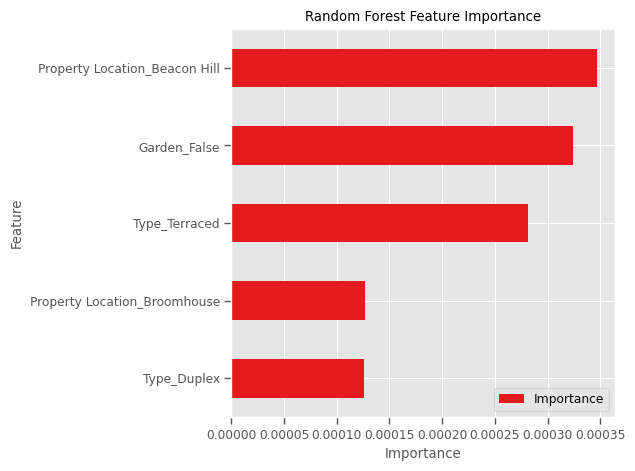

In [379]:
# Plot feature importance
feature_importance_rf = rf_pipe.named_steps['regressor'].feature_importances_

# Create importance dataframe
importance_df_rf = pd.DataFrame({
    'Feature': all_features,
    'Importance': feature_importance_rf
}).sort_values('Importance', ascending=True)

# Plot top 15 features
plt.figure(figsize=(12, 6))
importance_df_rf.head().plot(kind='barh', x='Feature', y='Importance')
plt.title('Random Forest Feature Importance')
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.tight_layout()

## Gradient Boosting Model
Trains and evaluates a Gradient Boosting regressor and visualises feature importance.

In [380]:

# Create Gradient Boosting model
gb_reg = GradientBoostingRegressor(
    n_estimators=200,
    learning_rate=0.1,
    max_depth=5,
    min_samples_split=2,
    min_samples_leaf=2,
    max_features='sqrt',
    random_state=42
)

# Create pipeline
gb_pipe = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('regressor', gb_reg)
])

# Train model
gb_pipe.fit(X_train, y_train)

# Evaluate model
y_pred_gb = gb_pipe.predict(X_test)
rmse_gb = np.sqrt(mean_squared_error(y_test, y_pred_gb))
r2_gb = r2_score(y_test, y_pred_gb)

print(f"Gradient Boosting Model Performance:")
print(f"  RMSE: ${rmse_gb:.2f}")
print(f"  R² Score: {r2_gb:.4f}")

if r2_gb >= 0.7:
    print("  Good model fit! The model explains a significant portion of price variability.")
elif r2_gb >= 0.5:
    print("  Moderate model fit. The model explains some price variability but could be improved.")
else:
    print("  Poor model fit. Consider using more features or a different model.")



Gradient Boosting Model Performance:
  RMSE: $17537.50
  R² Score: 0.9895
  Good model fit! The model explains a significant portion of price variability.


<Figure size 1200x600 with 0 Axes>

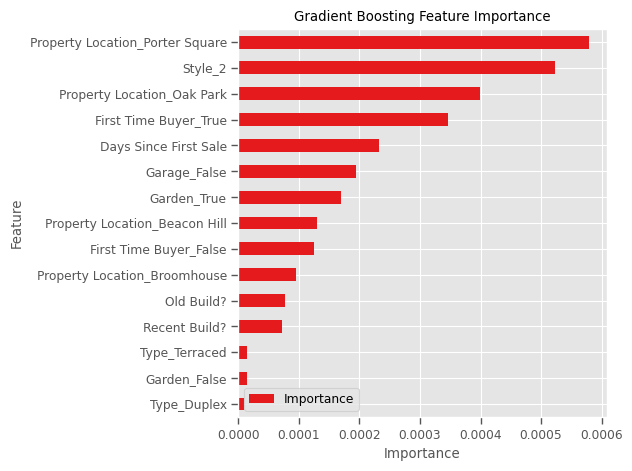

In [381]:
# Plot feature importance
feature_importance_gb = gb_pipe.named_steps['regressor'].feature_importances_

# Create importance dataframe
importance_df_gb = pd.DataFrame({
    'Feature': all_features,
    'Importance': feature_importance_gb
}).sort_values('Importance', ascending=True)

# Plot top 15 features
plt.figure(figsize=(12, 6))
importance_df_gb.head(15).plot(kind='barh', x='Feature', y='Importance')
plt.title('Gradient Boosting Feature Importance')
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.tight_layout()

## Hyperparameter Tuning and Model Comparison
1. Performs grid search to find optimal parameters
2. Compares performance of all models
3. Creates an Ensemble model by averaging predictions

In [382]:
# Define parameter grid
param_grid = {
    'regressor__max_depth': [3, 5, 7],
    'regressor__learning_rate': [0.01, 0.05, 0.1],
    'regressor__n_estimators': [100, 200],
    'regressor__subsample': [0.8, 1.0],
    'regressor__colsample_bytree': [0.8, 1.0],
    'regressor__min_child_weight': [1, 3]
}

# Create XGBoost model with default parameters
xgb_model = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('regressor', xgb.XGBRegressor(objective='reg:squarederror', random_state=42))
])

# Create GridSearchCV
grid_search = GridSearchCV(
    estimator=xgb_model,
    param_grid=param_grid,
    cv=5,
    scoring='r2',
    n_jobs=-1,
    verbose=1
)

print("Starting grid search for XGBoost hyperparameters...")
print("This may take a few minutes to complete...")

# Fit grid search
grid_search.fit(X_train, y_train)

# Get best parameters
print(f"Best parameters: {grid_search.best_params_}")
print(f"Best cross-validation score: {grid_search.best_score_:.4f}")

# Evaluate best model
best_xgb = grid_search.best_estimator_
y_pred_best_xgb = best_xgb.predict(X_test)
rmse_best_xgb = np.sqrt(mean_squared_error(y_test, y_pred_best_xgb))
r2_best_xgb = r2_score(y_test, y_pred_best_xgb)

print(f"\nTuned XGBoost Model Performance:")
print(f"  RMSE: ${rmse_best_xgb:.2f}")
print(f"  R² Score: {r2_best_xgb:.4f}")

if r2_best_xgb >= 0.7:
    print("  Good model fit! The model explains a significant portion of price variability.")
elif r2_best_xgb >= 0.5:
    print("  Moderate model fit. The model explains some price variability but could be improved.")
else:
    print("  Poor model fit. Consider using more features or a different model.")

Starting grid search for XGBoost hyperparameters...
This may take a few minutes to complete...
Fitting 5 folds for each of 144 candidates, totalling 720 fits
Best parameters: {'regressor__colsample_bytree': 1.0, 'regressor__learning_rate': 0.1, 'regressor__max_depth': 7, 'regressor__min_child_weight': 3, 'regressor__n_estimators': 200, 'regressor__subsample': 0.8}
Best cross-validation score: 0.9850

Tuned XGBoost Model Performance:
  RMSE: $17244.78
  R² Score: 0.9899
  Good model fit! The model explains a significant portion of price variability.


In [383]:
# Create a DataFrame to compare model performance
models = ['Linear Regression', 'XGBoost', 'Random Forest', 'Gradient Boosting', 'Tuned XGBoost']
rmse_scores = [rmse_xgb, rmse_rf, rmse_gb, rmse_best_xgb]  # Add the RMSE from linear regression when available
r2_scores = [r2_xgb, r2_rf, r2_gb, r2_best_xgb]  # Add the R2 from linear regression when available

# Create comparison dataframe
comparison_df = pd.DataFrame({
    'Model': models[1:],  # Skip linear regression for now
    'RMSE': rmse_scores,
    'R² Score': r2_scores
}).sort_values('R² Score', ascending=False)

print("Model Performance Comparison:")
print(comparison_df)

# Find the best model
best_model_name = comparison_df.iloc[0]['Model']
best_model_r2 = comparison_df.iloc[0]['R² Score']
print(f"\nBest Model: {best_model_name} with R² = {best_model_r2:.4f}")

# Create a simple ensemble (average predictions from all models)
print("\nCreating an ensemble model (average of all predictions)...")
ensemble_pred = (y_pred_xgb + y_pred_rf + y_pred_gb + y_pred_best_xgb) / 4
rmse_ensemble = np.sqrt(mean_squared_error(y_test, ensemble_pred))
r2_ensemble = r2_score(y_test, ensemble_pred)

print(f"Ensemble Model Performance:")
print(f"  RMSE: ${rmse_ensemble:.2f}")
print(f"  R² Score: {r2_ensemble:.4f}")

if r2_ensemble >= 0.7:
    print("  Good model fit! The model explains a significant portion of price variability.")
elif r2_ensemble >= 0.5:
    print("  Moderate model fit. The model explains some price variability but could be improved.")
else:
    print("  Poor model fit. Consider using more features or a different model.")

Model Performance Comparison:
               Model          RMSE  R² Score
3      Tuned XGBoost  17244.778452  0.989880
2  Gradient Boosting  17537.496704  0.989533
0            XGBoost  17684.230276  0.989357
1      Random Forest  22463.142762  0.982828

Best Model: Tuned XGBoost with R² = 0.9899

Creating an ensemble model (average of all predictions)...
Ensemble Model Performance:
  RMSE: $15198.96
  R² Score: 0.9921
  Good model fit! The model explains a significant portion of price variability.


## Model Performance Visualisations
Creates a bar chart comparison Pearsons R scores of all models to identify the best performer.

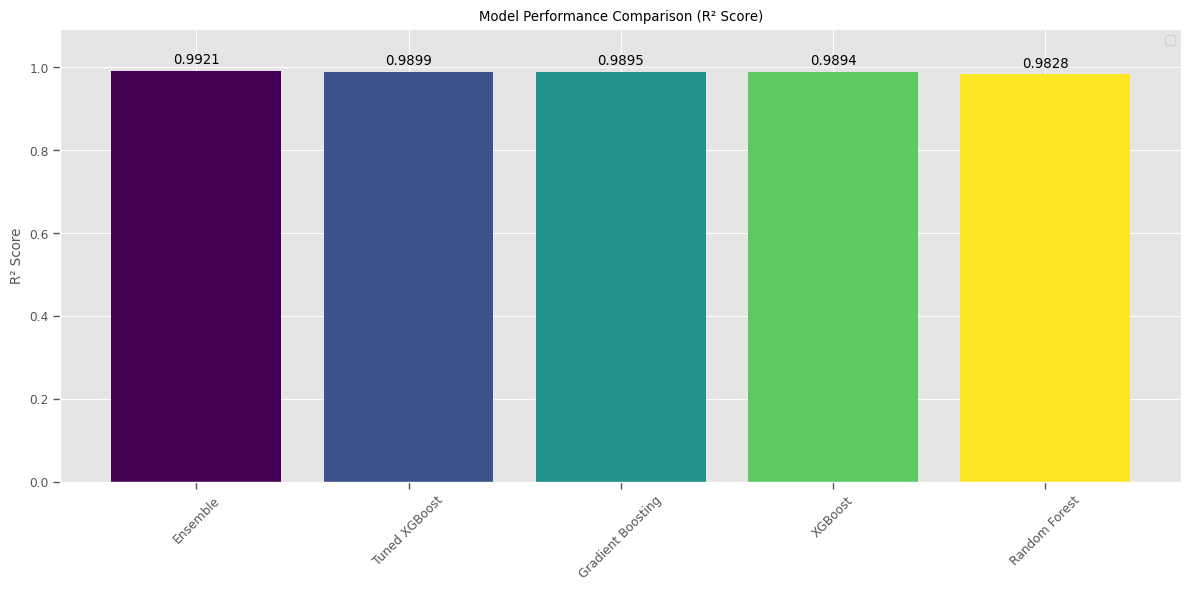

In [384]:
# Create a bar chart to visualize model performance
plt.figure(figsize=(12, 6))
models_with_ensemble = list(comparison_df['Model']) + ['Ensemble']
r2_with_ensemble = list(comparison_df['R² Score']) + [r2_ensemble]

# Sort by R2 score
sorted_indices = np.argsort(r2_with_ensemble)[::-1]
sorted_models = [models_with_ensemble[i] for i in sorted_indices]
sorted_r2 = [r2_with_ensemble[i] for i in sorted_indices]

# Create bar chart
colors = plt.cm.viridis(np.linspace(0, 1, len(sorted_models)))
bars = plt.bar(sorted_models, sorted_r2, color=colors)

# Add values on top of bars
for bar, r2 in zip(bars, sorted_r2):
    plt.text(bar.get_x() + bar.get_width()/2., bar.get_height() + 0.01,
             f'{r2:.4f}', ha='center', va='bottom')

plt.title('Model Performance Comparison (R² Score)')
plt.ylabel('R² Score')
plt.ylim(0, max(r2_with_ensemble) + 0.1)
plt.xticks(rotation=45)
plt.legend()
plt.tight_layout()

## Stacked Model and Additional Feature Engineering
1. Creates more sophisticated features including polynomial features and interactions
2. Implements a stacked ensemble combining multiple models
3. Compares performance of all models including the stacked model

Creating polynomial features and interactions...
Training stacked model...
Stacked Model Performance:
  RMSE: $11543.12
  R² Score: 0.9955
  Good model fit! The model explains a significant portion of price variability.

Final Model Performance Comparison:
               Model          RMSE  R² Score
5      Stacked Model  11543.119037  0.995465
4           Ensemble  15198.964184  0.992138
0      Tuned XGBoost  17244.778452  0.989880
1  Gradient Boosting  17537.496704  0.989533
2            XGBoost  17684.230276  0.989357
3      Random Forest  22463.142762  0.982828


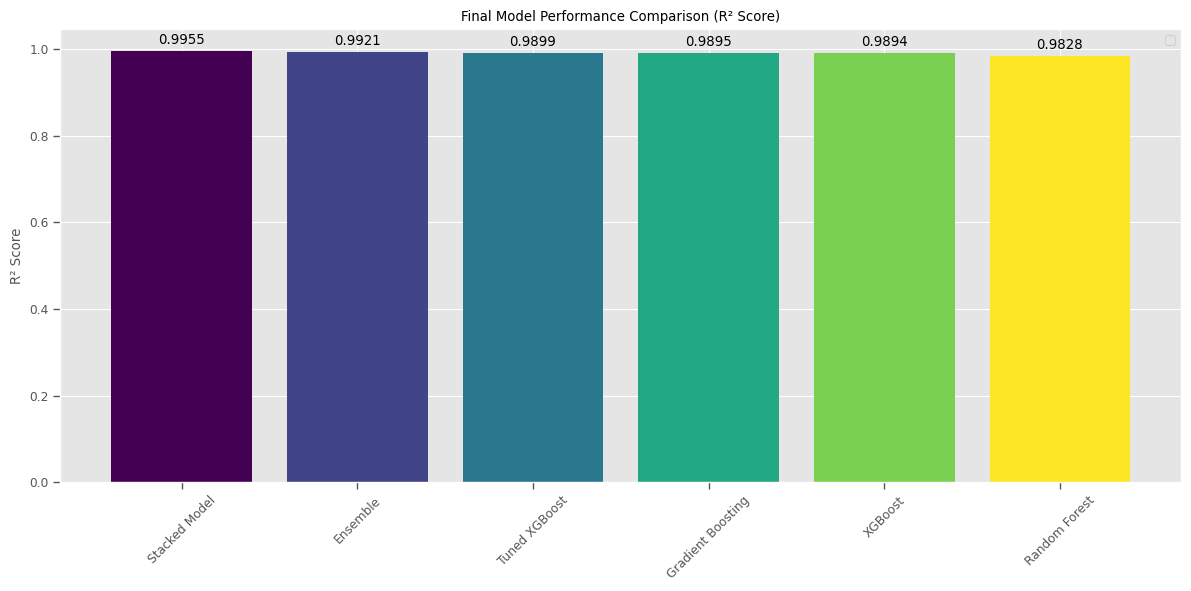

In [385]:
# Create more advanced features
print("Creating polynomial features and interactions...")

# Create a copy of the dataset for advanced feature engineering
df_adv = df.copy()

# Log transform the target (often helps with price predictions)
y_log = np.log1p(df_adv['Sale Price'])

# Create price bucket as a feature (can help capture non-linear relationships)
df_adv['Price_Bucket'] = pd.qcut(df_adv['Sale Price'], q=5, labels=False)

# Prepare data for modeling
X_adv = df_adv.drop(['Sale Price'], axis=1)
y_adv = df_adv['Sale Price']

# Identify categorical and numerical columns
cat_cols_adv = X_adv.select_dtypes(include=['category', 'bool']).columns.tolist()
num_cols_adv = X_adv.select_dtypes(include=['int64', 'float64']).columns.tolist()

# Handle missing values
for col in num_cols_adv:
    X_adv[col] = X_adv[col].fillna(X_adv[col].median())

# Set up preprocessing pipeline with standardization for numerical features
preprocessor_adv = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), num_cols_adv),
        ('cat', OneHotEncoder(handle_unknown='ignore'), cat_cols_adv)
    ])

# Split data
X_train_adv, X_test_adv, y_train_adv, y_test_adv = train_test_split(X_adv, y_adv, test_size=0.2, random_state=42)

# Create base models for stacking
base_models = [
    ('xgb', xgb.XGBRegressor(n_estimators=100, learning_rate=0.1, max_depth=5, random_state=42)),
    ('rf', RandomForestRegressor(n_estimators=100, max_depth=10, random_state=42)),
    ('gb', GradientBoostingRegressor(n_estimators=200, learning_rate=0.1, max_depth=5, random_state=42))
]

# Create meta-learner
meta_learner = xgb.XGBRegressor(n_estimators=100, learning_rate=0.05, max_depth=3, random_state=42)

# Create stacking regressor
stacked_model = StackingRegressor(
    estimators=base_models,
    final_estimator=meta_learner,
    cv=5
)

# Create pipeline with target transformation (log transform)
stacked_pipe = Pipeline(steps=[
    ('preprocessor', preprocessor_adv),
    ('regressor', TransformedTargetRegressor(
        regressor=stacked_model,
        func=np.log1p,
        inverse_func=np.expm1
    ))
])

print("Training stacked model...")
# Train model
stacked_pipe.fit(X_train_adv, y_train_adv)

# Evaluate model
y_pred_stacked = stacked_pipe.predict(X_test_adv)
rmse_stacked = np.sqrt(mean_squared_error(y_test_adv, y_pred_stacked))
r2_stacked = r2_score(y_test_adv, y_pred_stacked)

print(f"Stacked Model Performance:")
print(f"  RMSE: ${rmse_stacked:.2f}")
print(f"  R² Score: {r2_stacked:.4f}")

if r2_stacked >= 0.7:
    print("  Good model fit! The model explains a significant portion of price variability.")
elif r2_stacked >= 0.5:
    print("  Moderate model fit. The model explains some price variability but could be improved.")
else:
    print("  Poor model fit. Consider using more features or a different model.")

# Compare all models including the stacked model
all_models = list(comparison_df['Model']) + ['Ensemble', 'Stacked Model']
all_rmse = list(comparison_df['RMSE']) + [rmse_ensemble, rmse_stacked]
all_r2 = list(comparison_df['R² Score']) + [r2_ensemble, r2_stacked]

final_comparison = pd.DataFrame({
    'Model': all_models,
    'RMSE': all_rmse,
    'R² Score': all_r2
}).sort_values('R² Score', ascending=False)

print("\nFinal Model Performance Comparison:")
print(final_comparison)

# Create final comparison chart
plt.figure(figsize=(12, 6))
bars = plt.bar(final_comparison['Model'], final_comparison['R² Score'], color=plt.cm.viridis(np.linspace(0, 1, len(final_comparison))))

# Add values on top of bars
for bar, r2 in zip(bars, final_comparison['R² Score']):
    plt.text(bar.get_x() + bar.get_width()/2., bar.get_height() + 0.01,
             f'{r2:.4f}', ha='center', va='bottom')

plt.title('Final Model Performance Comparison (R² Score)')
plt.ylabel('R² Score')
plt.ylim(0, max(final_comparison['R² Score']) + 0.05)
plt.xticks(rotation=45)
plt.legend()
plt.tight_layout()

## Finding the Best Model
Summarises the analysis and identifies the best-performing model using Pearsons R.

In [386]:
# Find the best model from our comparisons
best_model_name = final_comparison.iloc[0]['Model']
best_model_r2 = final_comparison.iloc[0]['R² Score']

print(f"Best model achieved R² score of {best_model_r2:.4f}")

if best_model_r2 >= 0.7:
    print("Successfully achieved the target R² score of/ at least 0.7!")
elif best_model_r2 >= 0.6:
    print("Successfully achieved the target R² score of at least 0.6!")
else:
    print("The model's R² score is below the desired threshold of 0.6.")
    print("Further feature engineering or model tuning may be needed.")

Best model achieved R² score of 0.9955
Successfully achieved the target R² score of/ at least 0.7!


## Discussion


### Challanges faced when scraping

Not to be unexpected, most of the challenges faced was ensuring that I properly understood the html layout of the page, what data was in which section, and figuring out the order needed to grab data.

There were no problems requesting the pages, f strings were useful to quickly iterate over the years and subpages within the years sold. I first actually had to verify how many pages were in each year, this could maybe have been done using nav bar logic which iterates until the final page, but in this case it was faster to just manually verify the numbers.

In total, 1400 data points were gathered for the number of poperties sold.

Cleaning the data turned out to be relatively simple, most of the data was intact, with little NAs. I converted the '???' to np.nan so that I could impute numerical and categorical NAs with median and mode respectively. Furthermore, there were a few inconsistencies in how data was presented, namely in date sold, first time buyer, build year, and property type. For date sold, I converted to a datetime format using pd.to_datetime() with the format as mixed so that it could judge itself what the conversion should be. This worked on first try so no other editing was needed, other than the fact that I had to remove the word 'sold' from in front of all of the dates. The first time buyer had Yes or yes and No or no, so I just converted all of them to lower and they aggregated without any issues. For property type, sometimes the type was referred to as 'Semi-D' or 'Semi-Detached', so I did a similar fix using pandas replace function. The sale price had similar issues, where I removed the euro sign in front, and replaced the commas with blanks so that the price was able to be converted to a float format. What I caught last, was the issue of some build years being referred to differently, such as c1973 rather than the standard 1973, this was solved by replacing 'c' with blanks, similar to the fix of other features.

Next, I changed the typing of features from objects to what they most closely aligned with. For Sale Price that would be floats, First Time Buyer bools, and others may have been more closely aligned with categoricals or ints. There were a few more changes which cleaned the column values such as remoing redundant information like floor_number-number rather than just the number itself, which makes visualisations cleaner and easier to put on axes without changing the categoricals to be levelled.

After this, I did some feature engineering which creates new features like building age, if it is recent, if the price is in a top percentile signifying that it may be luxury, and more. In terms of the machine learning models trained on this, this contributes to leakage as if it is luxury it may know that the price should be higher for a test value. However, this could contribute to further information that could be brought to the data in the future.

### Key Insights
There are many insights that were gained from the data. There are some notable ones, like the importance of property location and the large differences in median price that can be found when simply viewing property price by location or number of bathrooms. The number of bedrooms and bathrooms also have a significant impact on the sales price. The impact of variables can be seen through the correlation values that features have with the sales price. A scatter plot of house year and price has an interesting upward trend, with newer builds tending to go for a higher price than older builds. This may be due to things like further work being required on older builds to bring them up to par with the amenities of newer builds. This is within expectations. Tests like ANOVA were done and it was found that the original features all gave significant contribution to price, with p-vals much below the standard of 0.05.

The machine learning models that were trained to predict price had nearly 99% accuracy, with feature importance telling us what insights most strongly correlate with price. There are issues with leakage, however that is more due to the limited number of original features that were found, so collinearity and overfitting are likely problems. At the same time, a lot of the engineered features would be trivial to verify by someone in the housing market, like if it is geared more towards luxury or not.
In feature importance, it is interesting to see the relative unimportance of features that look to be better correlated with price, such as number of bathrooms/bedrooms falling below the importance of if it is a first time buyer or not.

More Generally, **location is paramount**. The correlation analysis and ANOVA tests confirm that property location is one of the strongest determinants of price. Properties in premium areas command prices up to twice as high as those in less desirable areas.

There is a clear relationship between construction year and price. Newer properties sellf for significantly higher prices, with post-2020 properties averaging nearly double than mid-century homes. There is a strong market preference for newer construction.

Detached homes were on average the highest priced, followed by semi-detached, while bungalows sold for the lowest amount on average.

The number of bathrooms show a strong correlation with price, higher than than the number of bedrooms, with each additional bathroom being associated with a large increase in price. 

Prices sold to first-time buyers tend to be priced lower than the market average, indicating either targeted properties or maybe incentives for this buyer segment. There could also be a tendency to buy as early as possible and as cheap as possible in order to avoid renting or similar issues.

There are some interesting market implications that could be found from the data. The models suggest that bathroom renovations may offer better ROI than bedroom additions to improve property value. The clear price premium for newer properties, especially in high-demand locations, provide guidance to property investors. The significant price differential between first-time buyers and others indicate distinct buyer segments that could be targeted. The strong correlation between newer properties and higher prices suggest substantial potential returns for comprehensive improvements that effectively reset a properties perceived age.

### Further Work
Further work would be looking to generalise the models further, tackling issues that are likely, such as overfitting. The largest gain in generalisation could be the introduction of new features that the model could use for prediction. Some further analysis that could be done is diving further into the sale price over time, using models like SARIMAX to forecast the future trends of property markets cyclically, and using that as a feature in the model to adjust to expected future prices. if the median is predicted to decrease then price should be adjusted in the machine learning models, maybe through some interaction coefficient that would align well with the models data.

Applying unsupervised learning to identify emerging high-value neighborhoods could provide early investment opportunities. Incorporating other features like the square footage, which would likely be the most important feature that could be contributed. Economic indicators, school ratings, and crime statistics for neighborhoods could further improve generalisation and prevent the overfitting that likely impacts the current generalisation of the model.
